# 训练思路

Logic：仅预测撂荒地上光伏建设概率即可，加入多时序可以丰富样本信息、学习到增量样本表示

数据流：


输入：
1、训练样本（划分训练集、测试集合）：美国光伏正样本；
2、预测样本：美国光伏用地；

输出：得到

数据操作：

（先用QQ图观察各个数据的分布特征）对于符合正态分布特征可以直接进入聚类；

1、样本标准化；
2、


后期数据补齐（后期模型优化需要注意的point）
1、Y数据源统一的问题；
2、R语言包问题解决；d
3、提取光伏Y=1正标签对应的landcover序列

# Load Data

In [1]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']





gogogo


# GMM模块：基于数据密度驱动的环境相似性建模

In [2]:
# -*- coding: utf-8 -*-
"""
整合版本的GMM+深度学习训练管道
- 统一的GMM训练和深度学习流程
- 解决数据泄露：预处理器在Pipeline中
- 完整的负样本采样和模型评估
- 简化的API设计

Author: you + ChatGPT 
"""
from __future__ import annotations

import os
import warnings
from typing import List, Tuple, Dict, Any, Optional, Sequence

from sklearn.pipeline import Pipeline as SkPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer,
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, mean_absolute_error,
    roc_auc_score
)
from tqdm.auto import tqdm
from typing import Dict, List, Optional, Tuple


SkPipeline = Pipeline

# 深度学习库
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow available")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("❌ TensorFlow not available")

try:
    from scikeras.wrappers import KerasClassifier
    SCIKERAS_AVAILABLE = True
    print("✅ scikeras available")
except ImportError:
    SCIKERAS_AVAILABLE = False
    print("❌ scikeras not available (pip install scikeras)")

# SHAP（可选）
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP available")
except ImportError:
    SHAP_AVAILABLE = False
    print("❌ SHAP not available")

# 可视化设置
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# ------------------------------
# 修复：组合预处理器（解决数据泄露）
# ------------------------------
class CombinedPreprocessor(BaseEstimator, TransformerMixin):
    """
    组合预处理器：数值特征预处理 + 分类特征编码
    解决数据泄露问题：每次fit都在当前数据上重新拟合
    """
    
    def __init__(self, numeric_features: List[str], categorical_features: List[str]):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.numeric_preprocessor = None
        self.categorical_preprocessor = None
        self.feature_mappings = {}
        
    def fit(self, X, y=None):
        """拟合预处理器"""
        # 动态选择存在的特征
        available_numeric = [f for f in self.numeric_features if f in X.columns]
        available_categorical = [f for f in self.categorical_features if f in X.columns]
        
        if not available_numeric and not available_categorical:
            raise ValueError("没有找到任何可用的特征列")
        
        # 构建数值特征预处理器
        if available_numeric:
            self.numeric_preprocessor = make_column_transformer(
                # 对数变换特征
                (make_pipeline(
                    ReplaceInfWithNaN(), 
                    SimpleImputer(strategy="median"), 
                    SafeLog1p(),
                    QuantileTransformer(n_quantiles=min(1000, len(X)), output_distribution="normal", random_state=0)
                ), [f for f in available_numeric if f in ['GDPpc', 'GDPtot', 'Population', 'Powerdist']]),
                
                # 地形特征
                (make_pipeline(
                    ReplaceInfWithNaN(), 
                    SimpleImputer(strategy="median"),
                    PowerTransformer(method="yeo-johnson", standardize=True)
                ), [f for f in available_numeric if f in ['DEM', 'Slope']]),
                
                # 距离特征
                (make_pipeline(
                    ReplaceInfWithNaN(), 
                    SimpleImputer(strategy="median"), 
                    SafeLog1p(), 
                    RobustScaler()
                ), [f for f in available_numeric if f in ['GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']]),
                
                # 气候特征
                (make_pipeline(
                    ReplaceInfWithNaN(), 
                    SimpleImputer(strategy="median"), 
                    StandardScaler()
                ), [f for f in available_numeric if f in ['tas', 'gdmp', 'rsds', 'wind']]),
                
                remainder="drop"
            )
            self.numeric_preprocessor.fit(X)
        
        # 构建分类特征预处理器（修复LabelEncoder问题）
        if available_categorical:
            self.categorical_preprocessor = make_column_transformer(
                (make_pipeline(
                    SimpleImputer(strategy="most_frequent"),
                    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                ), available_categorical),
                remainder="drop"
            )
            self.categorical_preprocessor.fit(X)
            
            # 保存特征映射信息
            for feature in available_categorical:
                if feature in X.columns:
                    unique_values = X[feature].dropna().unique()
                    self.feature_mappings[feature] = {
                        'n_categories': len(unique_values),
                        'categories': unique_values.tolist(),
                        'n_values': len(unique_values)
                    }
        
        return self
    
    def transform(self, X):
        """转换特征"""
        # 动态选择存在的特征
        available_numeric = [f for f in self.numeric_features if f in X.columns]
        available_categorical = [f for f in self.categorical_features if f in X.columns]
        
        # 处理数值特征
        X_numeric_processed = None
        if self.numeric_preprocessor is not None and available_numeric:
            X_numeric_processed = self.numeric_preprocessor.transform(X)
        
        # 处理分类特征
        X_categorical_processed = None
        if self.categorical_preprocessor is not None and available_categorical:
            X_categorical_processed = self.categorical_preprocessor.transform(X)
        
        # 组合特征
        if X_numeric_processed is not None and X_categorical_processed is not None:
            X_combined = np.column_stack([X_numeric_processed, X_categorical_processed])
        elif X_numeric_processed is not None:
            X_combined = X_numeric_processed
        elif X_categorical_processed is not None:
            X_combined = X_categorical_processed
        else:
            raise ValueError("没有可用的特征进行转换")
        
        return X_combined
    
    def get_feature_info(self):
        """获取特征信息"""
        return self.feature_mappings

# ------------------------------
# Top-level, picklable transformers (no lambdas!)
# ------------------------------
class ReplaceInfWithNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X[~np.isfinite(X)] = np.nan
        return X

class SafeLog1p(BaseEstimator, TransformerMixin):
    def __init__(self, lower_bound: float = -1 + 1e-6):
        self.lower_bound = lower_bound
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X = np.where(X <= self.lower_bound, self.lower_bound, X)
        return np.log1p(X)

# ------------------------------
# Utilities
# ------------------------------
def get_adaptive_n_quantiles(n_samples: int) -> int:
    """Adaptive n_quantiles for QuantileTransformer: 10..1000 and ≤ n_samples."""
    return int(max(10, min(1000, n_samples)))

# ------------------------------
# Light-weight quality check helpers
# ------------------------------
def _cov_condition_number(X: np.ndarray) -> Dict[str, float]:
    X = np.asarray(X, dtype=float)
    C = np.cov(X, rowvar=False)
    C += np.eye(C.shape[0]) * 1e-12
    try:
        w = np.linalg.eigvalsh(C)
        w = np.clip(w, 0.0, None)
        w_min = float(np.min(w))
        w_max = float(np.max(w))
        cond = float(w_max / (w_min + 1e-18))
        return {"min_eig": w_min, "max_eig": w_max, "condition_number": cond, "eigen_ratio": cond}
    except np.linalg.LinAlgError:
        return {"min_eig": np.nan, "max_eig": np.nan, "condition_number": np.inf, "eigen_ratio": np.inf}

def comprehensive_data_quality_check(
    X: np.ndarray, feature_names: List[str] | None = None, verbose: bool = True
) -> Tuple[Dict[str, Any], List[Dict[str, Any]]]:
    X = np.asarray(X)
    n, d = X.shape
    var = np.nanvar(X, axis=0)
    zero_thr = 1e-12
    low_thr = 1e-4

    report: Dict[str, Any] = {
        "shape": (n, d),
        "nan_count": int(np.isnan(X).sum()),
        "inf_count": int(np.isinf(X).sum()),
        "zero_count": int((X == 0).sum()),
        "variance_range": (float(np.nanmin(var)), float(np.nanmax(var))),
        "zero_variance_count": int(np.sum(var <= zero_thr)),
        "low_variance_count": int(np.sum(var <= low_thr)),
    }
    cov_info = _cov_condition_number(X)
    report["covariance_analysis"] = cov_info

    if verbose:
        print("数据形状:", report["shape"])
        print("NaN值数量:", report["nan_count"])
        print("Inf值数量:", report["inf_count"])
        print("零值数量:", report["zero_count"])
        print("方差范围:", "[%.2e, %.2e]" % report["variance_range"])
        print("零方差特征数:", report["zero_variance_count"], "；低方差特征数:", report["low_variance_count"])
        print("协方差矩阵条件数: %.2e" % cov_info["condition_number"])
        print("最小/最大特征值: %.2e / %.2e" % (cov_info["min_eig"], cov_info["max_eig"]))

    recs: List[Dict[str, Any]] = []
    return report, recs

# ------------------------------
# Plot helper
# ------------------------------
def plot_loglik_vs_components(grid_results: Dict[str, Any], best_params: Dict[str, Any]) -> None:
    df = pd.DataFrame(grid_results)
    if "param_gmm__n_components" not in df.columns:
        warnings.warn("Grid results do not contain 'param_gmm__n_components'. Skipping plot.")
        return
    series = df.groupby("param_gmm__n_components")["mean_test_score"].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, marker="o")
    plt.axvline(x=best_params["gmm__n_components"], linestyle="--", label=f"Best: {best_params['gmm__n_components']}")
    plt.xlabel("n_components")
    plt.ylabel("CV mean log-likelihood (higher is better)")
    plt.title("Log-likelihood vs n_components (CV)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------
# 修复：主API（解决数据泄露）
# ------------------------------
def select_and_train_gmm(df_pos: pd.DataFrame, bandwidths=None):
    """
    修复版本的GMM训练函数（升级版）：
    - 解决数据泄露（预处理器进Pipeline）；
    - 搜索 n_init 与 reg_covar；
    - 打印单组合排行榜；
    - 分类型绘图并带误差条。
    """
    print(f"输入数据形状: {df_pos.shape}")

    if "landcover" in df_pos.columns:
        landcover_values = df_pos["landcover"].value_counts().sort_index()
        print("\n检查 landcover 分布:")
        print(f"唯一值: {sorted(df_pos['landcover'].unique())}")
        print(f"分布: {dict(landcover_values)}")

    LOG = ['GDPpc', 'GDPtot', 'Population', 'Powerdist']
    DEM_SLOPE = ['DEM', 'Slope']
    DIST = ['GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
    NORMAL = ['tas', 'gdmp', 'rsds', 'wind']
    CAT = ['landcover']

    all_numeric_features = LOG + DEM_SLOPE + DIST + NORMAL
    available_numeric = [f for f in all_numeric_features if f in df_pos.columns]
    available_categorical = [f for f in CAT if f in df_pos.columns]
    if not available_numeric and not available_categorical:
        raise ValueError("没有找到任何可用的特征列")

    # 预处理器
    print("\n 创建组合预处理器...")
    combined_preprocessor = CombinedPreprocessor(available_numeric, available_categorical)

    # 预处理探查
    print("测试预处理器...")
    X_test = combined_preprocessor.fit_transform(df_pos)
    print(f"预处理后特征形状: {X_test.shape}")

    # 质量检查
    quality_report, _ = comprehensive_data_quality_check(
        X_test, feature_names=[f"f{i}" for i in range(X_test.shape[1])], verbose=True
    )
    # print("\n数据质量概要：")
    # print(f"NaN: {quality_report['nan_count']}  |  Inf: {quality_report['inf_count']}")
    # print("方差范围: [%.2e, %.2e]" % quality_report["variance_range"])

    cond = quality_report["covariance_analysis"]["condition_number"]
    if cond > 1e12:
        # print("⚠️ 数值较不稳定，使用保守参数")
        gmm_params = dict(n_components=1, covariance_type="diag", reg_covar=1e-3, random_state=0)
    else:
        print("✅ 数值稳定，使用标准参数")
        gmm_params = dict(n_components=1, covariance_type="full", reg_covar=1e-6, random_state=0)

    # 完整Pipeline
    print("\n构建完整Pipeline（包含预处理器）...")
    full_pipe = Pipeline([
        ("preprocessor", combined_preprocessor),
        ("gmm", GaussianMixture(**gmm_params)),
    ])

    # 参数网格（新增 n_init 与 reg_covar）
    if bandwidths is not None and np.size(bandwidths) > 0:
        comps = sorted({int(max(1, round(float(b)))) for b in np.ravel(bandwidths)})
    else:
        comps = list(range(1, 16))
    cov_types = ["full", "diag"]
    n_init_list = [1, 5, 10]
    reg_list = [1e-6, 1e-5, 1e-4]

    param_grid = {
        "gmm__n_components": comps,
        "gmm__covariance_type": cov_types,
        "gmm__n_init": n_init_list,
        "gmm__reg_covar": reg_list,
    }

    print("\n开始网格搜索 (5折交叉验证)...")


    grid = GridSearchCV(
        estimator=full_pipe,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=1,
        error_score="raise"
    )

    # 进度条（按网格规模粗略估计）
    total_iters = len(comps) * len(cov_types) * len(n_init_list) * len(reg_list)
    print("\n开始训练...")
    with tqdm(total=total_iters, desc="GMM训练") as pbar:
        grid.fit(df_pos)
        pbar.update(total_iters)

    # 结果
    best_params = grid.best_params_
    best_score  = grid.best_score_
    best_pipe   = grid.best_estimator_

    print("\n" + "=" * 60)
    print("训练完成！最佳参数:")
    print("=" * 60)
    print(f"n_components   : {best_params['gmm__n_components']}")
    print(f"covariance_type: {best_params['gmm__covariance_type']}")
    print(f"n_init         : {best_params['gmm__n_init']}")
    print(f"reg_covar      : {best_params['gmm__reg_covar']:.1e}")
    print(f"最佳CV均值对数似然: {best_score:.6f}")

    # --- 打印排行榜（单组合粒度） ---
    res = pd.DataFrame(grid.cv_results_)
    cols = [
        "param_gmm__n_components",
        "param_gmm__covariance_type",
        "param_gmm__n_init",
        "param_gmm__reg_covar",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
    leaderboard = res[cols].sort_values("mean_test_score", ascending=False)
    print("\nTop-15 单组合排行榜（越高越好）:")
    print(leaderboard.head(15).to_string(index=False))

    # --- 两条曲线 + 误差条（每个 cov、K 选取该组最佳组合的 std） ---
    try:
        plot_cv_by_covariance_with_errorbars(grid.cv_results_, best_params)
    except Exception as e:
        print(f"⚠️ 分类型误差条绘图失败: {e}")

    # 经典的（跨类型平均）的总览图（可选）
    try:
        plot_loglik_vs_components(grid.cv_results_, best_params)
    except Exception as e:
        print(f"⚠️ 总览图绘制失败: {e}")

    # 边界提醒
    if (best_params["gmm__n_components"] == max(comps)
        and best_params["gmm__covariance_type"] == "full"):
        print("\n💡 提示：最佳模型在 K 上触到上界，后续可扩大 K 或继续细化 reg_covar 网格。")

    # 保存Pipeline
    model_filename = f"gmm_model_{best_params['gmm__n_components']}c_fixed.pkl"
    try:
        joblib.dump(best_pipe, model_filename)
        print(f"\n✅ 完整Pipeline已保存到: {model_filename}")
    except Exception as e:
        print(f"⚠️ 模型保存失败: {e}")

    return best_pipe


# ------------------------------
# 修复：评分API（提升便捷性）
# ------------------------------
def score_env(
    gmm_pipeline: Pipeline,
    df_query: pd.DataFrame,
    method: str = 'sigmoid',
    sigmoid_alpha: float = 1.0,
    reference_stats: Dict | None = None,
    return_logdens: bool = False,
):
    """
    一致性评分函数（支持固定标定）：
    - 优先使用 gmm_pipeline.calibration_（若存在），否则用 reference_stats，
      再否则退回当前批次自适应。
    - 支持 method ∈ {'sigmoid','minmax','zscore'}。
    - 可返回 logdens 以便后续分析。

    reference_stats 可包含的键：
      - 对 sigmoid/zscore：'mu' 或 'mean'，以及可选 'std'
      - 对 minmax：'min','max'
    """
    # 1) 预处理 + GMM打分（log域更稳定）
    Xp = gmm_pipeline.named_steps['preprocessor'].transform(df_query)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    logdens = gmm.score_samples(Xp)
    dens = np.exp(logdens)

    # 2) 选择标定参数来源：pipeline.calibration_ > reference_stats > 当前批次
    calib = getattr(gmm_pipeline, "calibration_", None)
    ref = reference_stats or {}
    # 统一取值
    def pick(keys, default=None):
        for k in keys:
            if calib and k in calib:
                return calib[k]
            if k in ref:
                return ref[k]
        return default

    mu  = pick(['mu', 'mean'], float(logdens.mean()))
    std = pick(['std'], float(logdens.std()))
    vmin = pick(['min'], float(logdens.min()))
    vmax = pick(['max'], float(logdens.max()))

    # 3) 计算分数（带数值保护）
    if method == 'sigmoid':
        # 数值裁剪，避免 exp 溢出
        x = np.clip(sigmoid_alpha * (logdens - mu), -50.0, 50.0)
        scores = 1.0 / (1.0 + np.exp(-x))
    elif method == 'minmax':
        rng = max(vmax - vmin, 1e-12)
        scores = (logdens - vmin) / rng
        # 防止轻微越界
        scores = np.clip(scores, 0.0, 1.0)
    elif method == 'zscore':
        s = std if std and std > 1e-12 else 1.0
        scores = (logdens - mu) / s
    else:
        raise ValueError(f"Unknown method: {method}")

    # 4) 输出统计（用当前批次的，用于日志/回写）
    stats_out = {
        'mean': float(logdens.mean()),
        'mu': float(mu),
        'std': float(std),
        'min': float(logdens.min()),
        'max': float(logdens.max()),
    }

    if return_logdens:
        return dens, scores, stats_out, logdens
    else:
        return dens, scores, stats_out







✅ TensorFlow available
✅ scikeras available
✅ SHAP available


# Deeplearning: 深度学习模块

## 负采样与模型训练

In [ ]:


# ------------------------------
# 6. 负样本生成
# ------------------------------

def generate_negative_samples_from_abandon(df_positive, df_prediction_pool, features_no_coords, 
                                           gmm_pipeline, negative_ratio=0.1, random_state=42,
                                           sampling_strategy="mixed", difficulty_levels=3):
    """
    从预测样本池中生成负样本（分层采样策略）
    
    改进点：
    - 分层采样：避免只选择极端低分样本
    - 多难度级别：简单、中等、困难负样本组合
    - 采样质量验证：交叉验证评估采样效果
    
    Parameters:
    -----------
    df_positive : 正样本数据
    df_prediction_pool : 预测样本池（从中抽取负样本）
    features_no_coords : 特征列表
    gmm_pipeline : 训练好的GMM管道
    negative_ratio : 负样本比例
    random_state : 随机种子
    sampling_strategy : str
        - "simple": 主要选择低分样本
        - "mixed": 混合各难度级别（推荐）
        - "hard": 主要选择高分样本
    difficulty_levels : int, 难度分层数（默认3层）
    
    Returns:
    --------
    df_negative_samples : 被选中的负样本
    df_remaining_prediction : 剩余的预测样本
    df_combined_training : 组合的训练数据（正样本+负样本）
    """
    print("=" * 60)
    print("分层采样策略：从预测样本池中生成负样本")
    print("=" * 60)
    
    try:
        np.random.seed(random_state)
        
        # 1. 使用GMM对预测样本池进行评分
        print("对预测样本池进行GMM环境相似度评分...")
        dens, env_scores, stats = score_env(gmm_pipeline, df_prediction_pool[features_no_coords],
                                           method='sigmoid', sigmoid_alpha=0.2)
        
        # 2. 为预测样本池添加评分
        df_prediction_with_scores = df_prediction_pool.copy()
        df_prediction_with_scores['gmm_score'] = env_scores
        df_prediction_with_scores['gmm_density'] = dens
        
        # 3. 分析评分分布
        score_percentiles = np.percentile(env_scores, [10, 25, 50, 75, 90, 95])
        print(f"GMM评分分布: P10={score_percentiles[0]:.3f}, P25={score_percentiles[1]:.3f}, P50={score_percentiles[2]:.3f}, P75={score_percentiles[3]:.3f}, P90={score_percentiles[4]:.3f}")
        
        # 4. 计算需要的样本数
        n_positive = len(df_positive)
        n_negative_total = int(n_positive * negative_ratio)
        n_prediction_pool = len(df_prediction_pool)
        
        print(f"正样本数量: {n_positive}")
        print(f"预测样本池数量: {n_prediction_pool}")
        print(f"负样本数量: {n_negative_total} (比例: {negative_ratio:.1f})")
        
        # 5. 定义分层采样策略
        strategy_weights = {
            "simple": [0.7, 0.25, 0.05],      # 主要选低分
            "mixed": [0.4, 0.4, 0.2],         # 平衡选择
            "hard": [0.2, 0.3, 0.5]           # 主要选高分
        }
        
        if sampling_strategy not in strategy_weights:
            print(f"⚠️ 未知采样策略: {sampling_strategy}，使用默认策略: mixed")
            sampling_strategy = "mixed"
        
        layer_weights = strategy_weights[sampling_strategy][:difficulty_levels]
        layer_weights = np.array(layer_weights) / np.sum(layer_weights)  # 归一化
        
        # 6. 根据评分分位数定义难度阈值
        if difficulty_levels == 3:
            # 简单（0-30%）、中等（30-70%）、困难（70-95%）
            score_thresholds = np.percentile(env_scores, [0, 30, 70, 95])
        elif difficulty_levels == 2:
            # 简单（0-50%）、困难（50-90%）
            score_thresholds = np.percentile(env_scores, [0, 50, 90])
        else:
            # 动态分层
            score_thresholds = np.percentile(env_scores, np.linspace(0, 85, difficulty_levels + 1))
        
        print(f"采样策略: {sampling_strategy}")
        print(f"层级权重: {layer_weights}")
        print(f"评分阈值: {score_thresholds}")
        
        # 7. 分层采样
        print("执行分层采样...")
        layer_samples = []
        layer_info = []
        
        for i in range(difficulty_levels):
            layer_names = ["简单", "中等", "困难", "极难", "超难"]
            layer_name = layer_names[i] if i < len(layer_names) else f"层级{i+1}"
            
            # 定义当前层级的评分范围
            if i == difficulty_levels - 1:  # 最后一层
                mask = env_scores >= score_thresholds[i]
            else:
                mask = (env_scores >= score_thresholds[i]) & (env_scores < score_thresholds[i+1])
            
            layer_candidates = df_prediction_with_scores[mask]
            n_layer_needed = int(n_negative_total * layer_weights[i])
            
            print(f"  {layer_name}层级: 候选{len(layer_candidates):,}个, 需要{n_layer_needed:,}个")
            
            if len(layer_candidates) == 0:
                print(f"    ⚠️ {layer_name}层级无候选样本，跳过")
                continue
            
            # 在该层级内随机采样
            if n_layer_needed > len(layer_candidates):
                print(f"    ⚠️ {layer_name}层级需求超过候选数，全部使用")
                layer_sample = layer_candidates
            else:
                layer_sample = layer_candidates.sample(n=n_layer_needed, random_state=random_state+i)
            
            layer_samples.append(layer_sample)
            layer_info.append({
                'layer_name': layer_name,
                'n_candidates': len(layer_candidates),
                'n_sampled': len(layer_sample),
                'weight': layer_weights[i],
                'score_range': (score_thresholds[i], 
                               score_thresholds[i+1] if i < difficulty_levels-1 else np.inf),
                'mean_score': layer_sample['gmm_score'].mean(),
                'std_score': layer_sample['gmm_score'].std()
            })
        
        # 8. 合并所有层级的样本
        if not layer_samples:
            raise ValueError("没有成功采样到任何负样本")
        
        df_negative_samples = pd.concat(layer_samples, ignore_index=True)
        
        # 9. 剩余预测样本（去除被选中的负样本）
        negative_indices = set(df_negative_samples.index)
        remaining_mask = ~df_prediction_with_scores.index.isin(negative_indices)
        df_remaining_prediction = df_prediction_with_scores[remaining_mask].copy()
        
        # ✅ 保留GMM评分列！
        # df_remaining_prediction = df_remaining_prediction.drop(['gmm_score', 'gmm_density'], axis=1, errors='ignore')
        
        print(f"总计采样负样本: {len(df_negative_samples):,}个")
        print(f"剩余预测样本: {len(df_remaining_prediction):,}个")
        
        # 10. 快速验证采样质量
        print("验证采样质量...")
        try:
            from sklearn.model_selection import cross_val_score
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler
            from sklearn.pipeline import Pipeline
            
            # 准备验证数据
            X_pos = df_positive[features_no_coords]
            X_neg = df_negative_samples[features_no_coords]
            X_combined = pd.concat([X_pos, X_neg], ignore_index=True)
            y_combined = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg))])
            
            # 简单的验证管道
            val_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=random_state, max_iter=1000))
            ])
            
            cv_scores = cross_val_score(val_pipeline, X_combined, y_combined, 
                                      cv=3, scoring='f1', n_jobs=-1)
            
            quality_score = np.mean(cv_scores)
            print(f"采样质量评估 (3折CV F1): {quality_score:.3f} ± {np.std(cv_scores):.3f}")
            
            if quality_score > 0.8:
                print("✅ 采样质量良好")
            elif quality_score > 0.6:
                print("⚠️ 采样质量一般，建议调整策略")
            else:
                print("❌ 采样质量较差，建议重新采样")
                
        except Exception as e:
            print(f"⚠️ 质量验证失败: {e}")
        
        # 11. 输出分层统计
        print("\n分层采样统计:")
        print("-" * 40)
        for info in layer_info:
            print(f"{info['layer_name']}层级:")
            print(f"  评分范围: [{info['score_range'][0]:.3f}, {info['score_range'][1]:.3f})")
            print(f"  候选/采样: {info['n_candidates']:,} / {info['n_sampled']:,}")
            print(f"  平均评分: {info['mean_score']:.3f} ± {info['std_score']:.3f}")
        
        # 12. 准备训练数据（只在训练数据中移除GMM评分列）
        df_positive_labeled = df_positive[features_no_coords].copy()
        df_positive_labeled['label'] = 1
        df_positive_labeled['sample_type'] = 'positive'
        
        # ✅ 修复：在负样本训练数据中移除GMM评分列，但保留在原始负样本中
        df_negative_labeled = df_negative_samples[features_no_coords].copy()
        df_negative_labeled['label'] = 0
        df_negative_labeled['sample_type'] = 'negative_sample'
        
        # 组合训练数据
        df_combined_training = pd.concat([df_positive_labeled, df_negative_labeled], ignore_index=True)
        
        print(f"\n训练数据集构建完成:")
        print(f"  正样本: {len(df_positive_labeled)} | 负样本: {len(df_negative_labeled)} | 总计: {len(df_combined_training)}")
        print(f"  正样本比例: {df_combined_training['label'].mean():.3f}")
        print(f"\n剩余预测数据: {len(df_remaining_prediction)}")
        
        # 13. 可视化采样结果
        visualize_sampling_results(env_scores, df_negative_samples, score_thresholds, layer_info)
        
        return df_negative_samples, df_remaining_prediction, df_combined_training
        
    except Exception as e:
        print(f"❌ Error in generate_negative_samples_from_abandon: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def train_and_evaluate_model(df_combined_training, features_no_coords, gmm_preprocessor, 
                             test_size=0.2, val_size=0.2, epochs=50, 
                             batch_size=32, random_state=42,
                             hidden_layers=[128,64,32], dropout_rate=0.3, learning_rate=0.001,
                             plot_learning_curve=True, learning_curve_epochs=30):
    """训练深度学习分类器"""
    
    print("=" * 60)
    print("训练深度学习分类器")
    print("=" * 60)
    
    try:
        # ✅ 在函数开头设置所有随机种子
        import numpy as np
        import tensorflow as tf
        from sklearn.base import clone
        
        # 设置随机种子确保可重复性
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        # 如果使用GPU，还需要设置这些
        try:
            tf.config.experimental.enable_op_determinism()
            print("✅ TensorFlow确定性模式已启用")
        except Exception:
            print("ℹ️ TensorFlow确定性模式设置跳过")
        
        # 检查 scikeras 可用性
        try:
            from scikeras.wrappers import KerasClassifier
            SCIKERAS_AVAILABLE = True
        except ImportError:
            SCIKERAS_AVAILABLE = False
        
        # 1. 准备原始数据
        print("准备原始数据...")
        X = df_combined_training[features_no_coords]
        y = df_combined_training['label'].values.astype(int)
        
        print(f"原始特征: {X.shape}")
        print(f"标签分布: 正样本={y.sum()}, 负样本={len(y)-y.sum()}, 正样本比例={y.mean():.3f}")
        
        # 2. 先划分原始数据（未预处理的）
        print("先划分原始数据...")
        
        # 第一次划分：分离测试集
        X_temp, X_test_raw, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # 第二次划分：从剩余数据中分离验证集
        val_size_adjusted = val_size / (1 - test_size)
        X_train_raw, X_val_raw, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
        )
        
        print(f"原始数据划分完成:")
        print(f"  训练集: {X_train_raw.shape} (正样本比例: {y_train.mean():.3f})")
        print(f"  验证集: {X_val_raw.shape} (正样本比例: {y_val.mean():.3f})")
        print(f"  测试集: {X_test_raw.shape} (正样本比例: {y_test.mean():.3f})")
        
        # 3. 克隆预处理器并在训练集上重新拟合
        print("在训练集上重新拟合预处理器...")
        
        # 克隆GMM预处理器的结构
        train_preprocessor = clone(gmm_preprocessor)
        
        # 在训练集（正+负样本）上重新拟合
        train_preprocessor.fit(X_train_raw)
        
        print("✅ 预处理器已在训练集上重新拟合（避免正样本偏差）")
        
        # 4. 学习曲线分析（在正式训练前）
        learning_curve_results = None
        if plot_learning_curve:
            try:
                print("\n执行学习曲线分析（仅训练集，无泄露）...")
                if not SCIKERAS_AVAILABLE:
                    raise ImportError("scikeras not available")
                
                # ✅ 仅使用训练集进行学习曲线分析
                learning_curve_results = plot_learning_curve_nn(
                    build_model_fn=build_deep_learning_model,
                    X_raw=X_train_raw,  
                    y=y_train,         
                    features_no_coords=features_no_coords,
                    gmm_preprocessor=gmm_preprocessor,  # ✅ 使用原始GMM预处理器
                    train_sizes=np.linspace(0.2, 1.0, 5),
                    cv_splits=5,
                    epochs=learning_curve_epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    hidden_layers=hidden_layers,
                    dropout_rate=dropout_rate,
                    scoring="f1",
                    random_state=random_state
                )
            except Exception as e:
                print(f"⚠️ 学习曲线分析失败: {e}")
        
        # 5. 分别transform三个子集
        print("分别预处理三个数据集...")
        
        X_train = train_preprocessor.transform(X_train_raw)
        X_val = train_preprocessor.transform(X_val_raw)
        X_test = train_preprocessor.transform(X_test_raw)
        
        print(f"预处理后数据形状:")
        print(f"  训练集: {X_train.shape}")
        print(f"  验证集: {X_val.shape}")
        print(f"  测试集: {X_test.shape}")
        
        # 6. 构建模型（确保使用相同的随机种子）
        print("构建深度学习模型...")
        input_dim = X_train.shape[1]
        
        # 再次设置种子确保模型初始化的一致性
        tf.random.set_seed(random_state)
        
        model = build_deep_learning_model(input_dim, hidden_layers, dropout_rate, learning_rate)
        
        # 7. 训练模型
        print("开始模型训练...")
        
        # 再次确保随机种子
        tf.random.set_seed(random_state)
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=1
        )
        
        # 8. 模型评估
        print("模型评估...")
        
        # 训练集评估
        y_train_pred = model.predict(X_train, verbose=0).ravel()
        y_train_bin = (y_train_pred > 0.5).astype(int)
        train_metrics = {
            'accuracy': accuracy_score(y_train, y_train_bin),
            'precision': precision_score(y_train, y_train_bin),
            'recall': recall_score(y_train, y_train_bin),
            'f1': f1_score(y_train, y_train_bin)
        }
        
        # 验证集评估
        y_val_pred = model.predict(X_val, verbose=0).ravel()
        y_val_bin = (y_val_pred > 0.5).astype(int)
        val_metrics = {
            'accuracy': accuracy_score(y_val, y_val_bin),
            'precision': precision_score(y_val, y_val_bin),
            'recall': recall_score(y_val, y_val_bin),
            'f1': f1_score(y_val, y_val_bin)
        }
        
        # 测试集评估
        y_test_pred = model.predict(X_test, verbose=0).ravel()
        y_test_bin = (y_test_pred > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        test_auc = auc(fpr, tpr)
        
        test_metrics = {
            'accuracy': accuracy_score(y_test, y_test_bin),
            'precision': precision_score(y_test, y_test_bin),
            'recall': recall_score(y_test, y_test_bin),
            'f1': f1_score(y_test, y_test_bin),
            'auc': test_auc
        }
        
        # 打印结果
        print(f"训练集性能: Acc={train_metrics['accuracy']:.4f} | P={train_metrics['precision']:.4f} | R={train_metrics['recall']:.4f} | F1={train_metrics['f1']:.4f}")
        print(f"验证集性能: Acc={val_metrics['accuracy']:.4f} | P={val_metrics['precision']:.4f} | R={val_metrics['recall']:.4f} | F1={val_metrics['f1']:.4f}")
        print(f"测试集性能: Acc={test_metrics['accuracy']:.4f} | P={test_metrics['precision']:.4f} | R={test_metrics['recall']:.4f} | F1={test_metrics['f1']:.4f} | AUC={test_metrics['auc']:.4f}")
        
        # 绘制训练结果
        plot_training_results(history, fpr, tpr, test_auc, y_test, y_test_pred)
        
        # 概率预测评估
        mse = mean_squared_error(y_test, y_test_pred)
        mae = mean_absolute_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        brier_score = np.mean((y_test - y_test_pred) ** 2)
        prob_metrics = {'mse': mse, 'mae': mae, 'rmse': rmse, 'brier_score': brier_score}
        
        results = {
            'model': model,
            'history': history,
            'splits': {
                'X_train': X_train, 'y_train': y_train,
                'X_val': X_val, 'y_val': y_val,
                'X_test': X_test, 'y_test': y_test
            },
            'preprocessor': train_preprocessor,  # 使用重新训练的预处理器
            'original_preprocessor': gmm_preprocessor,  # 保留原始GMM预处理器
            'metrics': {
                'train': train_metrics,
                'val': val_metrics,
                'test': test_metrics
            },
            'test_auc': test_auc,
            'probability_metrics': prob_metrics,
            'learning_curve_results': learning_curve_results  # 添加学习曲线结果
        }
        
        print("✅ 训练完成！已修复预处理偏差和随机种子问题")
        return results
        
    except Exception as e:
        print(f"❌ Error in train_and_evaluate_model: {e}")
        import traceback; traceback.print_exc()
        return None

# ------------------------------
# 7. 深度学习模型
# ------------------------------
def build_deep_learning_model(input_dim, hidden_layers=[128, 64, 32],
                              dropout_rate=0.3, learning_rate=0.001):
    """构建深度学习模型"""
    if not TENSORFLOW_AVAILABLE:
        raise ImportError("TensorFlow not available, cannot build deep learning model")

    print("Building deep learning model...")
    
    # ✅ 确保模型构建的随机性一致
    import tensorflow as tf
    
    inputs = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inputs)
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu',
                         kernel_regularizer=keras.regularizers.l2(1e-2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 'accuracy']
    )
    print(f"Input dim: {input_dim} | Hidden: {hidden_layers} | Params: {model.count_params():,}")
    return model

# ------------------------------
# 训练管道
# ------------------------------

def run_correct_training_pipeline(df_positive, df_prediction_pool, features_no_coords,
                                  negative_ratio=0.3, test_size=0.2, val_size=0.2,
                                  epochs=50, batch_size=32, random_state=42,
                                  hidden_layers=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001,
                                  run_shap=False, plot_learning_curve=True, learning_curve_epochs=30,
                                  sampling_strategy="mixed", difficulty_levels=3):
    """
    运行完整的正确训练管道（分层负样本采样）
    """
    print("=" * 80)
    print("正确的训练管道：分层负样本采样的完整流程")
    print("=" * 80)
    
    try:
        # 步骤1: 训练GMM模型
        print("\n步骤1: 训练GMM模型用于环境相似度评估")
        gmm_pipeline = select_and_train_gmm(df_positive[features_no_coords])
        
        if gmm_pipeline is None:
            raise ValueError("GMM模型训练失败")
        
        # 提取预处理器
        if hasattr(gmm_pipeline, 'named_steps') and 'preprocessor' in gmm_pipeline.named_steps:
            gmm_preprocessor = gmm_pipeline.named_steps['preprocessor']
        else:
            gmm_preprocessor = gmm_pipeline
        
        # 步骤2: 分层负样本采样
        print("\n步骤2: 分层负样本采样")
        df_negative_samples, df_remaining_prediction, df_combined_training = generate_negative_samples_from_abandon(
            df_positive, df_prediction_pool, features_no_coords, gmm_pipeline,
            negative_ratio=negative_ratio, random_state=random_state,
            sampling_strategy=sampling_strategy, difficulty_levels=difficulty_levels
        )
        
        if df_combined_training is None:
            raise ValueError("负样本生成失败")
        
        # 步骤3: 训练深度学习模型（包含学习曲线分析）
        print("\n步骤3: 训练深度学习分类模型（包含学习曲线分析）")
        training_results = train_and_evaluate_model(
            df_combined_training, features_no_coords, gmm_preprocessor,
            test_size=test_size, val_size=val_size, epochs=epochs,
            batch_size=batch_size, random_state=random_state,
            hidden_layers=hidden_layers, dropout_rate=dropout_rate, learning_rate=learning_rate,
            plot_learning_curve=plot_learning_curve, learning_curve_epochs=learning_curve_epochs
        )
        
        if training_results is None:
            raise ValueError("模型训练失败")
        
        model = training_results['model']
        retrained_preprocessor = training_results['preprocessor']
        
        # 步骤4: 对剩余预测样本进行预测
        print("\n步骤4: 对剩余预测样本进行预测")
        X_remaining_processed = retrained_preprocessor.transform(df_remaining_prediction[features_no_coords])
        remaining_pred_prob = model.predict(X_remaining_processed, verbose=0).ravel()
        remaining_pred_binary = (remaining_pred_prob > 0.5).astype(int)
        
        print(f"剩余样本预测完成: {len(remaining_pred_prob)} 个样本")
        print(f"预测为正类的数量: {remaining_pred_binary.sum()}")
        print(f"预测为正类的比例: {remaining_pred_binary.mean():.3f}")
        print(f"平均预测概率: {remaining_pred_prob.mean():.3f}")
        
        # 步骤5: 合并负样本和预测结果
        print("\n步骤5: 合并负样本和预测结果")
        
        # ✅ 修复：确保GMM评分列保留在结果中
        negative_results = df_negative_samples.copy()
        negative_results['predicted_label'] = 0
        negative_results['predicted_prob'] = 0.0
        negative_results['sample_type'] = 'negative_sample'
        
        # 准备预测结果（保留GMM评分）
        prediction_results = df_remaining_prediction.copy()
        prediction_results['predicted_label'] = remaining_pred_binary
        prediction_results['predicted_prob'] = remaining_pred_prob
        prediction_results['sample_type'] = 'prediction'
        
        # 合并所有结果
        final_results = pd.concat([negative_results, prediction_results], ignore_index=True)
        
        # ✅ 验证GMM评分列是否存在
        print(f"\n检查GMM评分列:")
        print(f"  negative_results有gmm_score列: {'gmm_score' in negative_results.columns}")
        print(f"  prediction_results有gmm_score列: {'gmm_score' in prediction_results.columns}")
        print(f"  final_results有gmm_score列: {'gmm_score' in final_results.columns}")
        
        print(f"最终结果合并完成:")
        print(f"  负样本数量: {len(negative_results)} (标签=0)")
        print(f"  预测样本数量: {len(prediction_results)}")
        print(f"  总样本数量: {len(final_results)}")
        print(f"  最终预测为正类的总数: {final_results['predicted_label'].sum()}")
        print(f"  最终预测为正类的比例: {final_results['predicted_label'].mean():.3f}")
        
        # SHAP分析（可选）
        shap_results = None
        if run_shap:
            print("\n步骤6: SHAP特征重要性分析")
            shap_results = shap_analysis(
                model=model, 
                X_test=training_results['splits']['X_test'], 
                y_test=training_results['splits']['y_test'],
                feature_names=features_no_coords, 
                sample_size=1000
            )

        # 绘制完整的分析图表
        plot_complete_pipeline_results(
            training_results, final_results, negative_results, prediction_results
        )
        
        # 整合所有结果
        complete_results = {
            'gmm_pipeline': gmm_pipeline,
            'training_results': training_results,
            'final_results': final_results,
            'negative_samples': negative_results,
            'prediction_results': prediction_results,
            'training_data': df_combined_training,
            'learning_curve_analysis': training_results.get('learning_curve_results'),
            'config': {
                'negative_ratio': negative_ratio,
                'sampling_strategy': sampling_strategy,
                'difficulty_levels': difficulty_levels,
                'test_size': test_size,
                'val_size': val_size,
                'plot_learning_curve': plot_learning_curve,
                'learning_curve_epochs': learning_curve_epochs,
                'model_params': {
                    'hidden_layers': hidden_layers,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }
            },
            'shap_analysis': shap_results
        }
        
        # 打印学习曲线分析总结
        if training_results.get('learning_curve_results'):
            lc_analysis = training_results['learning_curve_results'].get('analysis', {})
            print("\n" + "=" * 60)
            print("学习曲线分析总结:")
            print("=" * 60)
            if lc_analysis.get('overfitting'):
                print("⚠️ 检测到过拟合，建议增加正则化或减少模型复杂度")
            elif lc_analysis.get('underfitting'):
                print("⚠️ 检测到欠拟合，建议增加模型复杂度或训练轮数")
            else:
                print("✅ 模型拟合程度良好")
                
            if lc_analysis.get('high_variance'):
                print("⚠️ 模型方差较高，建议增加数据量或正则化")
            else:
                print("✅ 模型方差适中")
                
            print(f"最终性能: {lc_analysis.get('final_performance', 'N/A'):.4f}")
        
        print("\n" + "=" * 80)
        print("✅ 分层负样本采样的训练管道执行完成！")
        print("=" * 80)
        
        return complete_results
        
    except Exception as e:
        print(f"❌ 训练管道执行失败: {e}")
        import traceback
        traceback.print_exc()
        return None

# ------------------------------
# 新增：绘制完整管道结果的函数
# ------------------------------
def plot_complete_pipeline_results(training_results, final_results, negative_results, prediction_results):
    """绘制完整管道的分析结果（配色、风格、字体仿 cross_target_analysis/percentile_small_multiples）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    # 统一配色
    base_colors = ['#D81B60', '#1E88E5', '#F9A825', '#00695C', '#A6CEE3', '#E31A1C', '#33A02C', '#FB9A99']
    # 训练/验证/测试配色
    metric_colors = [base_colors[0], base_colors[1], base_colors[2]]
    # 负样本/预测样本配色
    neg_color = base_colors[5]
    pred_color = base_colors[1]
    # 概率分布配色
    prob_color = base_colors[3]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

    # 1. 训练历史 Loss
    history = training_results['history']
    epochs = range(1, len(history.history['loss']) + 1)
    axes[0, 0].plot(epochs, history.history['loss'], color=metric_colors[0], lw=2.5, label='Training Loss')
    axes[0, 0].plot(epochs, history.history['val_loss'], color=metric_colors[1], lw=2.5, label='Validation Loss')
    axes[0, 0].set_title('Training History - Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(frameon=False)
    axes[0, 0].grid(True, alpha=0.3, linestyle='-')
    axes[0, 0].spines['top'].set_visible(False)

    # 2. 训练准确率
    axes[0, 1].plot(epochs, history.history['accuracy'], color=metric_colors[0], lw=2.5, label='Training Accuracy')
    axes[0, 1].plot(epochs, history.history['val_accuracy'], color=metric_colors[1], lw=2.5, label='Validation Accuracy')
    axes[0, 1].set_title('Training History - Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend(frameon=False)
    axes[0, 1].grid(True, alpha=0.3, linestyle='-')
    axes[0, 1].spines['top'].set_visible(False)

    # 3. 性能指标对比
    metrics_names = ['accuracy', 'precision', 'recall', 'f1']
    train_values = [training_results['metrics']['train'][m] for m in metrics_names]
    val_values = [training_results['metrics']['val'][m] for m in metrics_names]
    test_values = [training_results['metrics']['test'][m] for m in metrics_names]
    x = np.arange(len(metrics_names))
    width = 0.25

    axes[0, 2].bar(x - width, train_values, width, label='Train', alpha=0.85, color=metric_colors[0], edgecolor='black')
    axes[0, 2].bar(x, val_values, width, label='Validation', alpha=0.85, color=metric_colors[1], edgecolor='black')
    axes[0, 2].bar(x + width, test_values, width, label='Test', alpha=0.85, color=metric_colors[2], edgecolor='black')
    axes[0, 2].set_title('Performance Metrics Comparison')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels([n.capitalize() for n in metrics_names])
    axes[0, 2].legend(frameon=False)
    axes[0, 2].grid(True, alpha=0.3, linestyle='-')
    axes[0, 2].spines['top'].set_visible(False)

    # 4. GMM评分分布对比
    axes[1, 0].hist(prediction_results['gmm_score'], bins=50, alpha=0.7, 
                    label=f'Prediction Samples (n={len(prediction_results):,})', 
                    color=pred_color, edgecolor='black', density=True)
    if 'gmm_score' in negative_results.columns:
        axes[1, 0].hist(negative_results['gmm_score'], bins=30, alpha=0.8, 
                        label=f'Negative Samples (n={len(negative_results):,})', 
                        color=neg_color, edgecolor='black', density=True)
    axes[1, 0].set_xlabel('GMM Environmental Score')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('GMM Score Distribution')
    axes[1, 0].legend(frameon=False)
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')
    axes[1, 0].spines['top'].set_visible(False)

    # 5. 最终预测结果分布
    pred_counts = final_results['predicted_label'].value_counts().sort_index()
    bar_labels = ['Negative (0)', 'Positive (1)']
    bar_colors = [neg_color, pred_color]
    bars = axes[1, 1].bar(bar_labels, pred_counts.values, color=bar_colors, alpha=0.85, edgecolor='black')
    axes[1, 1].set_title('Final Prediction Distribution')
    axes[1, 1].set_ylabel('Count')
    for i, v in enumerate(pred_counts.values):
        axes[1, 1].text(i, v + max(pred_counts.values) * 0.01, 
                        f'{v:,}\n({v/len(final_results):.1%})', 
                        ha='center', va='bottom', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3, linestyle='-')
    axes[1, 1].spines['top'].set_visible(False)

    # 6. 预测概率分布
    prediction_probs = prediction_results['predicted_prob']
    axes[1, 2].hist(prediction_probs, bins=30, alpha=0.8, color=prob_color, edgecolor='black')
    axes[1, 2].axvline(x=0.5, color=base_colors[5], linestyle='--', linewidth=2, label='Threshold 0.5')
    axes[1, 2].axvline(x=prediction_probs.mean(), color=base_colors[2], linestyle='-', linewidth=2, 
                       label=f'Mean: {prediction_probs.mean():.3f}')
    axes[1, 2].set_title('Prediction Probability Distribution')
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].legend(frameon=False)
    axes[1, 2].grid(True, alpha=0.3, linestyle='-')
    axes[1, 2].spines['top'].set_visible(False)

    # 总标题
    plt.suptitle('Complete Pipeline Analysis Results', fontsize=18, weight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



def pu_eval_from_results(complete_results, thresholds=np.linspace(0.05, 0.95, 19), 
                        pi=None, max_f1_prime=10.0, min_detection_rate=0.001,
                        negative_ratio=None, cost_fp=1.0, cost_fn=1.0):
    """
    增强的PU学习评估 - 考虑正负样本融合、采样比例和错分类代价
    
    Parameters:
    -----------
    complete_results : dict, 完整的训练结果
    thresholds : array, 阈值范围
    pi : float, 正类先验概率（可选）
    max_f1_prime : float, F1'最大值限制，防止数值爆炸
    min_detection_rate : float, 最小检测率，低于此值标记为不可靠
    negative_ratio : float, 训练时使用的负样本比例（用于采样偏差修正）
    cost_fp : float, False Positive的代价权重
    cost_fn : float, False Negative的代价权重
    
    Returns:
    --------
    dict : 包含完整评估表格、最佳结果和建议
    """
    y_test = complete_results["training_results"]["splits"]["y_test"]
    X_test = complete_results["training_results"]["splits"]["X_test"]
    model = complete_results["training_results"]["model"]
    
    # 获取训练配置
    if negative_ratio is None:
        negative_ratio = complete_results.get("config", {}).get("negative_ratio", 0.3)
    
    # 计算训练时的样本比例
    training_pos_ratio = 1 / (1 + negative_ratio)
    
    # 使用完整未标注数据计算D，避免负样本偏差
    p_test = model.predict(X_test, verbose=0).ravel()
    p_unl = complete_results["prediction_results"]["predicted_prob"].values
    
    print(f"📊 增强PU评估 - 考虑采样偏差和错分类代价:")
    print(f"   - 训练时负样本比例: {negative_ratio:.1f} (正样本比例: {training_pos_ratio:.1%})")
    print(f"   - 测试集正样本: {(y_test==1).sum()}")
    print(f"   - 测试集负样本: {(y_test==0).sum()}")
    print(f"   - 未标注样本: {len(p_unl)}")
    print(f"   - 错分类代价比 (FP:FN): {cost_fp}:{cost_fn}")

    out = []
    pos_mask = (y_test == 1)
    neg_mask = (y_test == 0)
    
    for t in thresholds:
        # ✅ 完整的混淆矩阵分析
        TP = (p_test[pos_mask] >= t).sum()
        FN = (p_test[pos_mask] < t).sum()
        FP = (p_test[neg_mask] >= t).sum()
        TN = (p_test[neg_mask] < t).sum()
        
        # ✅ 基础指标
        R = TP / (TP + FN) if (TP + FN) > 0 else 0.0              # Recall
        P_biased = TP / (TP + FP) if (TP + FP) > 0 else 0.0       # Precision (biased by sampling)
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0            # False Positive Rate
        
        # ✅ PU学习核心指标
        D = (p_unl >= t).mean()                                    # Detection rate on unlabeled
        D_safe = max(D, min_detection_rate)
        
        # ✅ 采样比例修正的精确度
        if pi is not None:
            # 贝叶斯校正：考虑真实先验概率
            P_corrected = (R * pi) / (R * pi + FPR * (1 - pi)) if (R * pi + FPR * (1 - pi)) > 0 else 0.0
        else:
            P_corrected = P_biased
        
        # ✅ 多种F1分数计算
        # 1. 标准F1（可能有偏差）
        F1_standard = 2 * P_biased * R / (P_biased + R) if (P_biased + R) > 0 else 0.0
        
        # 2. 代价敏感F1
        if (cost_fp + cost_fn) > 0:
            weighted_precision = P_biased * cost_fp / (cost_fp + cost_fn)
            weighted_recall = R * cost_fn / (cost_fp + cost_fn)
            F1_cost_sensitive = 2 * weighted_precision * weighted_recall / (weighted_precision + weighted_recall) if (weighted_precision + weighted_recall) > 0 else 0.0
        else:
            F1_cost_sensitive = F1_standard
        
        # 3. PU-F1 (原版)
        F1p_raw = (R * R) / D_safe
        F1_prime_original = min(F1p_raw, max_f1_prime)
        
        # 4. 增强PU-F1：轻微惩罚False Positive Rate
        F1_prime_enhanced = (R * R) / max(D_safe + FPR * 0.1, min_detection_rate)
        F1_prime_enhanced = min(F1_prime_enhanced, max_f1_prime)
        
        # 5. 采样偏差修正F1
        sampling_bias_factor = abs(training_pos_ratio - 0.5) * 2  # 0-1之间
        F1_sampling_corrected = F1_standard * (1 - sampling_bias_factor * 0.2)
        
        # ✅ 可靠性评估（考虑多个因素）
        if D >= 0.01 and FPR < 0.5:
            reliability = "High"
        elif D >= 0.001 and FPR < 0.7: 
            reliability = "Medium"
        else:
            reliability = "Low"
        
        row = {
            "thr": float(t),
            # 混淆矩阵
            "TP": int(TP), "FN": int(FN), "FP": int(FP), "TN": int(TN),
            # 基础指标
            "R": float(R), "P_biased": float(P_biased), "FPR": float(FPR),
            "P_corrected": float(P_corrected) if pi else None,
            # PU指标
            "D": float(D),
            # 多种F1分数
            "F1_standard": float(F1_standard),
            "F1_cost_sensitive": float(F1_cost_sensitive),
            "F1_prime": float(F1_prime_original),  # 保持原名称兼容性
            "F1_prime_enhanced": float(F1_prime_enhanced),
            "F1_sampling_corrected": float(F1_sampling_corrected),
            # 质量评估
            "F1_prime_raw": float(F1p_raw),
            "reliability": reliability,
            "is_stable": D >= min_detection_rate,
            "sampling_bias_factor": float(sampling_bias_factor)
        }
        
        # PU-Learning指标（如果提供先验概率）
        if pi is not None:
            alpha = 0.7
            constraint_met = D >= alpha * pi
            
            prec_pu = (R * pi) / D_safe
            f1_pu = 2 * prec_pu * R / max(prec_pu + R, 1e-12)
            
            row.update({
                "Prec_PU": float(prec_pu), 
                "F1_PU": float(f1_pu),
                "constraint_D_ge_alpha_pi": constraint_met,
                "alpha_pi": alpha * pi
            })
            
        out.append(row)

    # ✅ 智能阈值选择策略（支持多种F1）
    best_result = select_optimal_threshold(out, pi, cost_fp, cost_fn)
    recommendation = get_threshold_recommendation(out, best_result, pi, negative_ratio)
    
    return {
        "table": out, 
        "best": best_result,
        "reliable_count": len([r for r in out if r["reliability"] != "Low"]),
        "recommendation": recommendation,
        "summary": generate_pu_summary(out, best_result, pi, negative_ratio),
        "config": {
            "negative_ratio": negative_ratio,
            "training_pos_ratio": training_pos_ratio,
            "cost_fp": cost_fp,
            "cost_fn": cost_fn,
            "sampling_bias_factor": best_result.get("sampling_bias_factor", 0)
        }
    }


def select_optimal_threshold(results, pi=None, cost_fp=1.0, cost_fn=1.0):
    """
    智能阈值选择策略 - 支持多种评估标准
    """
    # 筛选可靠结果
    reliable_results = [r for r in results if r["reliability"] != "Low"]
    
    if not reliable_results:
        print("⚠️ 所有阈值的检测率都过低，选择检测率最高的")
        return max(results, key=lambda r: r["D"])
    
    # 选择最优F1标准
    if pi is not None:
        # 有先验概率：优先PU-F1
        constraint_satisfied = [r for r in reliable_results 
                              if r.get("constraint_D_ge_alpha_pi", True)]
        if constraint_satisfied:
            print("✅ 基于满足约束的PU-F1选择最佳阈值")
            return max(constraint_satisfied, key=lambda r: r["F1_PU"])
        else:
            print("⚠️ 无阈值满足约束，使用最优F1_PU")
            return max(reliable_results, key=lambda r: r.get("F1_PU", 0))
    elif cost_fp != cost_fn:
        # 有代价差异：使用代价敏感F1
        print(f"✅ 基于代价敏感F1选择最佳阈值 (FP代价:{cost_fp}, FN代价:{cost_fn})")
        return max(reliable_results, key=lambda r: r["F1_cost_sensitive"])
    else:
        # 默认：使用增强F1'
        print("✅ 基于增强F1'选择最佳阈值")
        return max(reliable_results, key=lambda r: r["F1_prime_enhanced"])


def get_threshold_recommendation(results, best_result, pi=None, negative_ratio=None):
    """增强的阈值建议 - 考虑采样偏差"""
    best_d = best_result["D"]
    best_thresh = best_result["thr"]
    best_r = best_result["R"]
    best_fpr = best_result["FPR"]
    
    # 基础建议
    if best_d >= 0.05:
        base_msg = f"✅ 推荐阈值 {best_thresh:.3f} (覆盖率 {best_d:.1%}，召回率 {best_r:.1%})"
    elif best_d >= 0.01:
        base_msg = f"⚠️ 阈值 {best_thresh:.3f} 可用但保守 (覆盖率 {best_d:.1%}，召回率 {best_r:.1%})"
    else:
        base_msg = f"❌ 阈值 {best_thresh:.3f} 过于保守 (覆盖率仅 {best_d:.1%})"
    
    # 误报率警告
    if best_fpr > 0.3:
        fpr_msg = f" | ⚠️ 误报率较高 ({best_fpr:.1%})"
    elif best_fpr > 0.1:
        fpr_msg = f" | ⚠️ 误报率中等 ({best_fpr:.1%})"
    else:
        fpr_msg = f" | ✅ 误报率较低 ({best_fpr:.1%})"
    
    # 采样偏差提醒
    if negative_ratio is not None:
        training_pos_ratio = 1 / (1 + negative_ratio)
        if abs(training_pos_ratio - 0.5) > 0.2:
            bias_msg = f" | ⚠️ 训练样本比例偏差较大 (正样本{training_pos_ratio:.1%})"
        else:
            bias_msg = f" | ✅ 训练样本比例适中 (正样本{training_pos_ratio:.1%})"
    else:
        bias_msg = ""
    
    return base_msg + fpr_msg + bias_msg


def generate_pu_summary(results, best_result, pi=None, negative_ratio=None):
    """生成增强的PU学习评估摘要"""
    reliable_count = len([r for r in results if r["reliability"] != "Low"])
    total_count = len(results)
    
    summary = {
        "total_thresholds": total_count,
        "reliable_thresholds": reliable_count,
        "reliability_ratio": reliable_count / total_count,
        "best_threshold": best_result["thr"],
        "best_recall": best_result["R"],
        "best_detection_rate": best_result["D"],
        "best_fpr": best_result["FPR"],
        "best_f1_prime": best_result["F1_prime"],
        "best_f1_enhanced": best_result["F1_prime_enhanced"],
        "best_f1_cost_sensitive": best_result["F1_cost_sensitive"]
    }
    
    if pi is not None:
        summary.update({
            "prior_probability": pi,
            "best_f1_pu": best_result.get("F1_PU", None),
            "constraint_satisfied": best_result.get("constraint_D_ge_alpha_pi", None)
        })
        
    if negative_ratio is not None:
        training_pos_ratio = 1 / (1 + negative_ratio)
        summary.update({
            "negative_ratio": negative_ratio,
            "training_pos_ratio": training_pos_ratio,
            "sampling_bias_factor": best_result.get("sampling_bias_factor", 0)
        })
    
    return summary


def plot_pu_metrics_enhanced(pu_results, pi=None):
    """增强的PU指标可视化 - 显示多种F1分数和混淆矩阵信息"""
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # 设置字体
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    df = pd.DataFrame(pu_results["table"])
    best_result = pu_results["best"]
    config = pu_results.get("config", {})
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 核心PU指标
    ax1 = axes[0, 0]
    ax1.plot(df['thr'], df['R'], 'o-', label='R (Recall)', color='#1F78B4', linewidth=2)
    ax1.plot(df['thr'], df['D'], 's-', label='D (Detection Rate)', color='#33A02C', linewidth=2)
    ax1.plot(df['thr'], df['FPR'], '^-', label='FPR (False Positive Rate)', color='#FF7F00', linewidth=2)
    
    ax1.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7, 
                label=f"Best: {best_result['thr']:.3f}")
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Rate')
    ax1.set_title('Core PU Learning Metrics')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # 2. 多种F1分数对比
    ax2 = axes[0, 1]
    f1_display_original = np.clip(df['F1_prime'], 0, 10)
    f1_display_enhanced = np.clip(df['F1_prime_enhanced'], 0, 10)
    
    ax2.plot(df['thr'], f1_display_original, '^-', label="F1' Original", color='#E31A1C', linewidth=2)
    ax2.plot(df['thr'], f1_display_enhanced, 's-', label="F1' Enhanced", color='#6A3D9A', linewidth=2)
    ax2.plot(df['thr'], df['F1_cost_sensitive'], 'o-', label="F1 Cost-Sensitive", color='#FF7F00', linewidth=2)
    
    if pi is not None and 'F1_PU' in df.columns:
        ax2.plot(df['thr'], df['F1_PU'], 'd-', label="F1-PU", color='#1F78B4', linewidth=2)
    
    ax2.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score Variants')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 10)
    
    # 3. 可靠性和偏差分析
    ax3 = axes[1, 0]
    
    # 标记可靠性
    reliable_mask = df['reliability'] == 'High'
    medium_mask = df['reliability'] == 'Medium'
    low_mask = df['reliability'] == 'Low'
    
    if reliable_mask.any():
        ax3.scatter(df.loc[reliable_mask, 'thr'], df.loc[reliable_mask, 'F1_prime_enhanced'], 
                   color='green', s=60, label='High Reliability', alpha=0.7)
    if medium_mask.any():
        ax3.scatter(df.loc[medium_mask, 'thr'], df.loc[medium_mask, 'F1_prime_enhanced'], 
                   color='orange', s=60, label='Medium Reliability', alpha=0.7)
    if low_mask.any():
        ax3.scatter(df.loc[low_mask, 'thr'], df.loc[low_mask, 'F1_prime_enhanced'], 
                   color='red', s=60, label='Low Reliability', alpha=0.7)
    
    ax3.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel("F1' Enhanced Score")
    ax3.set_title('Reliability Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 10)
    
    # 4. 采样偏差和代价信息
    ax4 = axes[1, 1]
    
    # 绘制采样偏差因子
    ax4.plot(df['thr'], df['sampling_bias_factor'], 'o-', 
             label=f"Sampling Bias Factor", color='#B15928', linewidth=2)
    ax4.plot(df['thr'], df['F1_sampling_corrected'], 's-', 
             label="F1 Sampling Corrected", color='#6A3D9A', linewidth=2)
    
    ax4.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Score / Factor')
    ax4.set_title('Sampling Bias Analysis')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细摘要
    print("\n" + "="*80)
    print("增强PU Learning评估摘要")
    print("="*80)
    print(f"最佳阈值: {best_result['thr']:.3f}")
    print(f"召回率 (R): {best_result['R']:.3f}")
    print(f"检测率 (D): {best_result['D']:.3f}")
    print(f"误报率 (FPR): {best_result['FPR']:.3f}")
    print(f"F1' 原版: {best_result['F1_prime']:.3f}")
    print(f"F1' 增强版: {best_result['F1_prime_enhanced']:.3f}")
    print(f"F1 代价敏感: {best_result['F1_cost_sensitive']:.3f}")
    if pi:
        print(f"F1-PU: {best_result.get('F1_PU', 'N/A'):.3f}")
    
    print(f"\n配置信息:")
    print(f"负样本比例: {config.get('negative_ratio', 'N/A'):.1f}")
    print(f"训练正样本比例: {config.get('training_pos_ratio', 'N/A'):.1%}")
    print(f"采样偏差因子: {config.get('sampling_bias_factor', 'N/A'):.3f}")
    print(f"错分类代价比 (FP:FN): {config.get('cost_fp', 1.0)}:{config.get('cost_fn', 1.0)}")
    
    print(f"\n可靠性: {best_result['reliability']}")
    print(f"建议: {pu_results['recommendation']}")



def enhanced_model_evaluation_with_pu(complete_results, pi_estimate=None, 
                                     traditional_metrics=True, pu_metrics=True,
                                     cost_fp=1.0, cost_fn=1.0):
    """
    增强的模型评估入口 - 保持原函数名
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    results = {}
    
    if traditional_metrics:
        # 传统评估
        y_test = complete_results["training_results"]["splits"]["y_test"]
        X_test = complete_results["training_results"]["splits"]["X_test"]
        model = complete_results["training_results"]["model"]
        
        y_pred_prob = model.predict(X_test, verbose=0).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        results["traditional"] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "auc": roc_auc_score(y_test, y_pred_prob),
            "note": "⚠️ These metrics may be biased due to negative sampling strategy"
        }
    
    if pu_metrics:
        # ✅ 使用增强的PU评估
        pu_results = pu_eval_from_results(
            complete_results, 
            pi=pi_estimate,
            max_f1_prime=None,
            min_detection_rate=0.001,
            negative_ratio=complete_results.get("config", {}).get("negative_ratio"),
            cost_fp=cost_fp,
            cost_fn=cost_fn
        )
        
        # ✅ 使用增强的可视化
        plot_pu_metrics_enhanced(pu_results, pi_estimate)
        
        results["pu_learning"] = pu_results
    
    return results

## 辅助函数

In [ ]:
# ------------------------------
# 11. 辅助函数
# ------------------------------

def _apply_gmm_preproc(X, gmm_preprocessor, features_no_coords):
    """辅助函数：应用已训练的GMM预处理器"""
    if isinstance(X, pd.DataFrame):
        return gmm_preprocessor.transform(X[features_no_coords])
    else:
        # 如果是numpy数组，转换为DataFrame
        df_temp = pd.DataFrame(X, columns=features_no_coords)
        return gmm_preprocessor.transform(df_temp)

def visualize_sampling_results(all_scores, negative_samples, thresholds, layer_info):
    """可视化分层采样结果（修复x轴标签显示问题）"""
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    
    # ✅ 强制设置字体和编码
    mpl.rcParams['font.family'] = ['Arial']
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12
    
    # ✅ 设置matplotlib后端
    try:
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        plt.rcParams['axes.unicode_minus'] = False
    except:
        pass

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    # 1. GMM评分分布 + 分层阈值
    axes[0].hist(all_scores, bins=50, alpha=0.7, label='All prediction samples', density=True, color='#A6CEE3', edgecolor='black')
    if 'gmm_score' in negative_samples.columns:
        negative_scores = negative_samples['gmm_score'].values
        axes[0].hist(negative_scores, bins=30, alpha=0.8, label='Selected negative samples', density=True, color='#E31A1C', edgecolor='black')
    # 添加分层阈值线
    for i, threshold in enumerate(thresholds[1:-1], 1):
        axes[0].axvline(threshold, color='#E31A1C', linestyle='--', alpha=0.7, linewidth=2)
    axes[0].set_xlabel('GMM Score')
    axes[0].set_ylabel('Density')
    axes[0].set_title('GMM Score Distribution & Stratified Thresholds')
    axes[0].legend(frameon=False)
    axes[0].grid(True, alpha=0.3, linestyle='--')

    # 2. 各层级采样统计（修复x轴标签）
    if layer_info:
        # ✅ 手动设置简化的标签名称
        layer_names_fixed = []
        for info in layer_info:
            original_name = info['layer_name']
            # 移除特殊字符，使用简单的ASCII字符
            if 'Easy' in original_name or '简单' in original_name:
                fixed_name = 'Easy'
            elif 'Medium' in original_name or '中等' in original_name:
                fixed_name = 'Medium'  
            elif 'Hard' in original_name or '困难' in original_name:
                fixed_name = 'Hard'
            else:
                # 使用索引作为备用
                fixed_name = f'Level_{len(layer_names_fixed)+1}'
            layer_names_fixed.append(fixed_name)
        
        n_sampled = [info['n_sampled'] for info in layer_info]
        n_candidates = [info['n_candidates'] for info in layer_info]
        x_pos = np.arange(len(layer_names_fixed))
        width = 0.35
        
        axes[1].bar(x_pos - width/2, n_candidates, width, label='Candidates', 
                   alpha=0.85, color='#A6CEE3', edgecolor='black')
        axes[1].bar(x_pos + width/2, n_sampled, width, label='Sampled', 
                   alpha=0.85, color='#FDBF6F', edgecolor='black')
        
        axes[1].set_xlabel('Difficulty Level')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Sample Count by Level')

        # ✅ 明确设置x轴刻度和标签
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(layer_names_fixed, rotation=0, ha='center', va='center')
        
        # ✅ 强制刷新轴标签
        axes[1].tick_params(axis='x', which='major', labelsize=12)
        
        axes[1].legend(frameon=False)
        axes[1].grid(True, alpha=0.3, linestyle='--')

        # 3. 各层级评分分布（修复x轴标签）
        for i, info in enumerate(layer_info):
            axes[2].errorbar(i, info['mean_score'], yerr=info['std_score'],
                             marker='o', capsize=5, label=layer_names_fixed[i],
                             color='#1F78B4', markersize=8, linewidth=2)
        axes[2].set_xlabel('Level Index')
        axes[2].set_ylabel('GMM Score')
        axes[2].set_title('Score Distribution by Level')

        # ✅ 明确设置x轴刻度和标签
        axes[2].set_xticks(range(len(layer_names_fixed)))
        axes[2].set_xticklabels(layer_names_fixed, rotation=0, ha='center', va='center')
        
        # ✅ 强制刷新轴标签
        axes[2].tick_params(axis='x', which='major', labelsize=12)
        
        axes[2].legend(frameon=False, loc='upper left')
        axes[2].grid(True, alpha=0.3, linestyle='--')

    plt.suptitle('Stratified Sampling Results', fontsize=18, fontweight='bold', y=1.05)
    
    # ✅ 强制刷新显示
    plt.draw()
    plt.show()



def learning_curve_with_pipeline(pipeline_fn, X, y, train_sizes, cv, scoring, random_state):
    """
    自定义学习曲线函数，确保每个CV折都重新构建和拟合完整Pipeline
    
    这对于PU学习特别重要，因为：
    1. 预处理器需要在每个训练折上重新拟合
    2. 避免负采样偏差传播到验证集
    """
    from sklearn.metrics import get_scorer
    import numpy as np
    
    scorer = get_scorer(scoring)
    n_samples = len(X)
    
    # 计算实际的训练集大小
    train_sizes_abs = [int(n_samples * size) for size in train_sizes]
    
    train_scores = []
    val_scores = []
    
    for train_size in train_sizes_abs:
        print(f"  训练集大小: {train_size}")
        
        fold_train_scores = []
        fold_val_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            print(f"    CV折 {fold_idx + 1}/{cv.n_splits}")
            
            # 从训练索引中采样指定数量的样本
            if len(train_idx) > train_size:
                train_subset_idx = np.random.choice(
                    train_idx, size=train_size, replace=False
                )
            else:
                train_subset_idx = train_idx
            
            # 准备数据
            X_train_fold = X.iloc[train_subset_idx]
            y_train_fold = y[train_subset_idx]
            X_val_fold = X.iloc[val_idx]
            y_val_fold = y[val_idx]
            
            # ✅ 每个折都创建新的Pipeline实例
            pipeline = pipeline_fn()
            
            # 训练
            pipeline.fit(X_train_fold, y_train_fold)
            
            # 评估
            train_score = scorer(pipeline, X_train_fold, y_train_fold)
            val_score = scorer(pipeline, X_val_fold, y_val_fold)
            
            fold_train_scores.append(train_score)
            fold_val_scores.append(val_score)
        
        train_scores.append(fold_train_scores)
        val_scores.append(fold_val_scores)
    
    return np.array(train_sizes_abs), np.array(train_scores), np.array(val_scores)


def plot_learning_curve_nn(
    build_model_fn,
    X_raw: pd.DataFrame,     # 仅训练集原始特征
    y: np.ndarray,           # 仅训练集标签
    features_no_coords: list,
    gmm_preprocessor,        # 原始GMM预处理器
    train_sizes=np.linspace(0.2, 1.0, 5),
    cv_splits: int = 5,
    epochs: int = 30,
    batch_size: int = 64,
    learning_rate: float = 0.001,
    hidden_layers=[128, 64, 32],
    dropout_rate: float = 0.3,
    scoring: str = "f1",
    random_state: int = 42
):
    """
    完全无数据泄露的学习曲线分析
    
    关键改进：
    1. 仅使用训练集数据
    2. 在每个CV折中重新拟合预处理器
    3. 考虑负采样的特殊性
    """
    import matplotlib as mpl
    from sklearn.base import clone
    
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14

    if not SCIKERAS_AVAILABLE:
        print("❌ scikeras 未安装，请安装 pip install scikeras 后再运行学习曲线")
        return None

    print("=" * 60)
    print("生成神经网络学习曲线（完全无泄露版本）")
    print("=" * 60)

    # ✅ 关键改进：创建完整的Pipeline，包含预处理器
    def make_complete_pipeline():
        """创建包含预处理和模型的完整管道"""
        
        # 克隆预处理器，确保每次CV都重新拟合
        fresh_preprocessor = clone(gmm_preprocessor)
        
        # 计算预处理后的维度（用于模型构建）
        temp_preprocessor = clone(gmm_preprocessor)
        temp_preprocessor.fit(X_raw[features_no_coords].head(10))
        X_sample = temp_preprocessor.transform(X_raw[features_no_coords].head(10))
        input_dim = X_sample.shape[1]
        
        def make_model():
            return build_model_fn(
                input_dim=input_dim,
                hidden_layers=hidden_layers,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate
            )

        # KerasClassifier
        clf = KerasClassifier(
            model=make_model,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            random_state=random_state
        )

        # ✅ 完整Pipeline：预处理器会在每个CV折中重新拟合
        pipeline = SkPipeline([
            ("preprocessor", fresh_preprocessor),
            ("classifier", clf)
        ])
        
        return pipeline

    # ✅ 使用自定义CV策略，考虑PU学习的特殊性
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    print(f"开始学习曲线分析...")
    print(f"数据集大小: {len(X_raw)} (仅训练集)")
    print(f"正样本比例: {y.mean():.3f}")
    print(f"训练样本规模: {train_sizes}")
    print(f"交叉验证折数: {cv_splits}")
    print(f"评估指标: {scoring}")
    try:
        # ✅ 使用自定义学习曲线函数
        train_sizes_abs, train_scores, val_scores = learning_curve_with_pipeline(
            pipeline_fn=make_complete_pipeline,
            X=X_raw[features_no_coords],
            y=y,
            train_sizes=train_sizes,
            cv=cv,
            scoring=scoring,
            random_state=random_state
        )

        train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
        val_mean,   val_std   = val_scores.mean(axis=1),   val_scores.std(axis=1)

        fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

        # 主图
        axes[0, 0].plot(train_sizes_abs, train_mean, marker="o", label=f"Train ({scoring})", color='#1F78B4', linewidth=2)
        axes[0, 0].fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.2, color='#1F78B4')
        axes[0, 0].plot(train_sizes_abs, val_mean, marker="s", label=f"CV ({scoring})", color='#E31A1C', linewidth=2)
        axes[0, 0].fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.2, color='#E31A1C')
        axes[0, 0].set_xlabel("Training size")
        axes[0, 0].set_ylabel(scoring.upper())
        axes[0, 0].set_title("Learning Curve")
        axes[0, 0].grid(True, alpha=0.3, linestyle='--')
        axes[0, 0].legend(frameon=False)

        # 过拟合检测
        gap = train_mean - val_mean
        axes[0, 1].plot(train_sizes_abs, gap, marker="^", color='#FDBF6F', linewidth=2)
        axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0, 1].set_xlabel("Training size")
        axes[0, 1].set_ylabel(f"Train - CV ({scoring})")
        axes[0, 1].set_title("Overfitting Gap")
        axes[0, 1].grid(True, alpha=0.3, linestyle='--')

        # 方差分析
        axes[1, 0].plot(train_sizes_abs, train_std, marker="o", label="Train Std", color='#1F78B4', linewidth=2)
        axes[1, 0].plot(train_sizes_abs, val_std, marker="s", label="CV Std", color='#E31A1C', linewidth=2)
        axes[1, 0].set_xlabel("Training size")
        axes[1, 0].set_ylabel(f"Std ({scoring})")
        axes[1, 0].set_title("Variance Analysis")
        axes[1, 0].legend(frameon=False)
        axes[1, 0].grid(True, alpha=0.3, linestyle='--')

        # 学习效率
        if len(train_sizes_abs) > 1:
            train_improvement = np.diff(train_mean)
            val_improvement = np.diff(val_mean)
            axes[1, 1].plot(train_sizes_abs[1:], train_improvement, marker="o", label="Train Improvement", color='#1F78B4', linewidth=2)
            axes[1, 1].plot(train_sizes_abs[1:], val_improvement, marker="s", label="CV Improvement", color='#E31A1C', linewidth=2)
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1, 1].set_xlabel("Training size")
            axes[1, 1].set_ylabel(f"Score Δ ({scoring})")
            axes[1, 1].set_title("Learning Efficiency")
            axes[1, 1].legend(frameon=False)
            axes[1, 1].grid(True, alpha=0.3, linestyle='--')
        else:
            axes[1, 1].set_visible(False)

        plt.suptitle('Neural Network Learning Curve Analysis', fontsize=18, fontweight='bold', y=1.05)
        plt.show()

        final_gap = gap[-1] if len(gap) > 0 else 0
        final_val_score = val_mean[-1] if len(val_mean) > 0 else 0
        final_train_score = train_mean[-1] if len(train_mean) > 0 else 0
        
        print("\n" + "=" * 50)
        print("学习曲线分析结果:")
        print("=" * 50)
        print(f"最终训练分数: {final_train_score:.4f}")
        print(f"最终验证分数: {final_val_score:.4f}")
        print(f"过拟合程度: {final_gap:.4f}")
        
        if final_gap > 0.1:
            print("⚠️ 可能存在过拟合")
        elif final_gap < -0.05:
            print("⚠️ 可能存在欠拟合")
        else:
            print("✅ 拟合程度良好")
            
        if val_std[-1] > 0.1:
            print("⚠️ 模型方差较高，考虑增加正则化")
        else:
            print("✅ 模型方差适中")

        return dict(
            train_sizes=train_sizes_abs,
            train_scores=train_scores,
            val_scores=val_scores,
            train_mean=train_mean,
            train_std=train_std,
            val_mean=val_mean,
            val_std=val_std,
            final_gap=final_gap,
            analysis={
                'overfitting': final_gap > 0.1,
                'underfitting': final_gap < -0.05,
                'high_variance': val_std[-1] > 0.1,
                'final_performance': final_val_score
            }
        )

    except Exception as e:
        print(f"❌ 学习曲线生成失败: {e}")
        import traceback
        traceback.print_exc()
        return None


def plot_training_results(history, fpr, tpr, test_auc, y_test, y_test_pred):
    """绘制训练结果（修复版本 - 只显示基础训练指标）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # 1. Loss曲线
    axes[0, 0].plot(epochs_range, history.history['loss'], label='Train Loss', color='#1F78B4', linewidth=2)
    axes[0, 0].plot(epochs_range, history.history['val_loss'], label='Val Loss', color='#E31A1C', linewidth=2)
    axes[0, 0].legend(frameon=False)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')

    # 2. Accuracy曲线
    axes[0, 1].plot(epochs_range, history.history['accuracy'], label='Train Acc', color='#1F78B4', linewidth=2)
    axes[0, 1].plot(epochs_range, history.history['val_accuracy'], label='Val Acc', color='#E31A1C', linewidth=2)
    axes[0, 1].legend(frameon=False)
    axes[0, 1].set_title('Training Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')

    # 3. ROC曲线
    axes[1, 0].plot(fpr, tpr, label=f'ROC (AUC={test_auc:.3f})', color='#33A02C', linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].legend(frameon=False)
    axes[1, 0].set_title('ROC Curve')
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')

    # 4. 预测概率分布
    axes[1, 1].hist(y_test_pred[y_test == 0], bins=30, alpha=0.7, label='Negative', color='#A6CEE3', edgecolor='black')
    axes[1, 1].hist(y_test_pred[y_test == 1], bins=30, alpha=0.7, label='Positive', color='#E31A1C', edgecolor='black')
    axes[1, 1].legend(frameon=False)
    axes[1, 1].set_title('Predicted Probability Distribution')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')

    plt.suptitle('Model Training Results', fontsize=16, fontweight='bold', y=0.98)
    plt.show()


def evaluate_model_performance(model, X_test, y_test, df_abandon_full, 
                              features_no_coords, gmm_preprocessor, df_combined, 
                              df_embedding, df_abandon, threshold=0.5):
    """简化的模型性能评估"""
    try:
        print("=" * 60)
        print("Model Performance Evaluation")
        print("=" * 60)

        y_test_pred = model.predict(X_test, verbose=0).ravel()
        y_test_bin = (y_test_pred > threshold).astype(int)

        test_accuracy = accuracy_score(y_test, y_test_bin)
        test_precision = precision_score(y_test, y_test_bin)
        test_recall = recall_score(y_test, y_test_bin)
        test_f1 = f1_score(y_test, y_test_bin)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        test_auc = auc(fpr, tpr)

        print(f"Acc={test_accuracy:.4f} | P={test_precision:.4f} | R={test_recall:.4f} | F1={test_f1:.4f} | AUC={test_auc:.4f}")

        # 撂荒地预测
        print("\n2. New Data Prediction (Abandoned Land):")
        X_abandon_processed = gmm_preprocessor.transform(df_abandon[features_no_coords])
        abandon_pred = model.predict(X_abandon_processed, verbose=0).ravel()
        abandon_bin = (abandon_pred > threshold).astype(int)
        n_pos = int(abandon_bin.sum()); n_total = len(abandon_pred)
        pos_ratio = n_pos / n_total
        print(f"   Total: {n_total} | Positive: {n_pos} | Ratio: {pos_ratio:.4f}")

        test_metrics = {
            'accuracy': test_accuracy, 'precision': test_precision,
            'recall': test_recall, 'f1': test_f1, 'auc': test_auc
        }
        prediction_results = {
            'abandon_predictions': abandon_pred,
            'abandon_predictions_binary': abandon_bin,
            'n_positive_predictions': n_pos,
            'n_total': n_total,
            'positive_ratio': pos_ratio
        }
        print("\n✅ Model evaluation completed successfully!")
        return test_metrics, prediction_results

    except Exception as e:
        print(f"❌ Model evaluation failed: {e}")
        import traceback; traceback.print_exc()
        return None, None


def shap_analysis(model, X_test, y_test, feature_names, sample_size=1000, 
                  show_detailed_analysis=True, show_interactions=False):
    """
    SHAP分析（修复matplotlib布局问题）
    """
    if not SHAP_AVAILABLE:
        print("❌ SHAP not available, skipping SHAP analysis")
        return None
        
    try:
        print("=" * 60)
        print("Enhanced SHAP Analysis - 增强版因子贡献度分析")
        print("=" * 60)
        
        if sample_size is None: 
            sample_size = min(100, len(X_test))
        X_sample = X_test[:sample_size].astype(np.float32)
        y_sample = y_test[:sample_size]
        
        feature_names = np.array(feature_names)
        
        print(f"分析样本数: {sample_size}")
        print(f"特征数量: {len(feature_names)}")
        
        # 1. 计算SHAP值
        print("计算SHAP值...")
        try:
            explainer = shap.DeepExplainer(model, X_sample[:50])
            shap_values = explainer.shap_values(X_sample)
            if isinstance(shap_values, list): 
                shap_values = shap_values[0]
            explainer_type = "DeepExplainer"
        except Exception as e:
            print(f"DeepExplainer失败: {e}; 使用GradientExplainer")
            explainer = shap.GradientExplainer(model, X_sample[:50])
            shap_values = explainer.shap_values(X_sample)
            if isinstance(shap_values, list): 
                shap_values = shap_values[0]
            explainer_type = "GradientExplainer"
        
        print(f"原始SHAP值形状: {shap_values.shape}")
        if len(shap_values.shape) == 3 and shap_values.shape[2] == 1:
            shap_values = shap_values.squeeze(axis=2)
            print(f"修正后SHAP值形状: {shap_values.shape}")
        print(f"✅ SHAP值计算完成 (使用 {explainer_type})")
        
        # ✅ 修复：设置matplotlib布局引擎
        import matplotlib as mpl
        mpl.rcParams['font.family'] = 'Arial'
        mpl.rcParams['axes.titlesize'] = 16
        mpl.rcParams['axes.labelsize'] = 14
        mpl.rcParams['xtick.labelsize'] = 12
        mpl.rcParams['ytick.labelsize'] = 12
        mpl.rcParams['legend.fontsize'] = 12
        
        # 强制使用经典布局引擎
        try:
            plt.rcParams['figure.layout'] = 'tight'
        except:
            pass
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 2.1 Summary Plot - 使用手动实现避免布局问题
        ax1 = axes[0, 0]
        try:
            # 直接使用自定义实现
            feature_importance = np.abs(shap_values).mean(axis=0)
            sorted_idx = np.argsort(feature_importance)[::-1][:15]  # 只显示top 15
            
            # 创建散点图显示SHAP值分布
            for i, feat_idx in enumerate(sorted_idx):
                y_pos = len(sorted_idx) - 1 - i
                feat_shap = shap_values[:, feat_idx]
                feat_values = X_sample[:, feat_idx]
                
                # 根据特征值着色
                scatter = ax1.scatter(feat_shap, [y_pos] * len(feat_shap), 
                                    c=feat_values, cmap='RdYlBu_r', alpha=0.6, s=20)
            
            ax1.set_yticks(range(len(sorted_idx)))
            ax1.set_yticklabels(feature_names[sorted_idx])
            ax1.set_xlabel('SHAP Value')
            ax1.set_title("SHAP Feature Contributions Distribution")
            ax1.grid(True, alpha=0.3)
            
            # 添加colorbar（避免布局冲突）
            try:
                cbar = plt.colorbar(scatter, ax=ax1)
                cbar.set_label('Feature Value')
            except:
                pass
            
        except Exception as e:
            print(f"Summary plot 失败: {e}，使用备用方案")
            feature_importance = np.abs(shap_values).mean(axis=0)
            sorted_idx = np.argsort(feature_importance)
            ax1.barh(range(len(feature_names)), feature_importance[sorted_idx], color='#1F78B4')
            ax1.set_yticks(range(len(feature_names)))
            ax1.set_yticklabels(feature_names[sorted_idx])
            ax1.set_title("SHAP Feature Importance (Backup Plot)")
            ax1.set_xlabel("Mean |SHAP Value|")
            ax1.grid(True, alpha=0.3)
        
        # 2.2 Bar Plot - 特征重要性排序
        ax2 = axes[0, 1]
        feature_importance = np.abs(shap_values).mean(axis=0)
        sorted_idx = np.argsort(feature_importance)
        ax2.barh(range(len(feature_names)), feature_importance[sorted_idx], color='#1F78B4')
        ax2.set_yticks(range(len(feature_names)))
        ax2.set_yticklabels(feature_names[sorted_idx])
        ax2.set_title("SHAP Feature Importance Ranking")
        ax2.set_xlabel("Mean |SHAP Value|")
        ax2.grid(True, alpha=0.3)
        
        # 2.3 正负贡献度统计
        ax3 = axes[1, 0]
        positive_contrib = (shap_values > 0).sum(axis=0) / len(shap_values)
        negative_contrib = (shap_values < 0).sum(axis=0) / len(shap_values)
        x_pos = np.arange(len(feature_names))
        ax3.barh(x_pos, positive_contrib, alpha=0.85, label='Positive Contribution %', color='#33A02C')
        ax3.barh(x_pos, -negative_contrib, alpha=0.85, label='Negative Contribution %', color='#E31A1C')
        ax3.set_yticks(x_pos)
        ax3.set_yticklabels(feature_names)
        ax3.set_xlabel('Contribution Frequency')
        ax3.set_title('Positive vs Negative Contributions')
        ax3.legend(frameon=False)
        ax3.grid(True, alpha=0.3)
        
        # 2.4 特征重要性vs预测准确性
        ax4 = axes[1, 1]
        y_pred = model.predict(X_sample, verbose=0).ravel()
        prediction_accuracy = np.abs(y_sample - y_pred)
        sample_importance = np.abs(shap_values).sum(axis=1)
        scatter = ax4.scatter(sample_importance, prediction_accuracy, alpha=0.7, 
                            c=y_sample, cmap='RdYlBu', edgecolor='k', s=30)
        ax4.set_xlabel('Total SHAP Importance')
        ax4.set_ylabel('Prediction Error')
        ax4.set_title('SHAP Importance vs Prediction Accuracy')
        ax4.grid(True, alpha=0.3)
        
        try:
            cbar = plt.colorbar(scatter, ax=ax4)
            cbar.set_label('True Label')
        except:
            pass
        
        plt.tight_layout()
        plt.show()
        
        if show_detailed_analysis:
            print("\n" + "=" * 50)
            print("详细因子贡献度分析")
            print("=" * 50)
            feature_stats = []
            for i, fname in enumerate(feature_names):
                shap_col = shap_values[:, i]
                stats = {
                    'feature': fname,
                    'mean_abs_shap': np.abs(shap_col).mean(),
                    'mean_shap': shap_col.mean(),
                    'std_shap': shap_col.std(),
                    'positive_ratio': (shap_col > 0).mean(),
                    'max_contribution': shap_col.max(),
                    'min_contribution': shap_col.min()
                }
                feature_stats.append(stats)
            stats_df = pd.DataFrame(feature_stats)
            stats_df = stats_df.sort_values('mean_abs_shap', ascending=False)
            print("Top 10 最重要特征的贡献度统计:")
            print(stats_df.head(10)[['feature', 'mean_abs_shap', 'mean_shap', 'positive_ratio']].to_string(index=False))
        
        analysis_report = {
            'shap_values': shap_values,
            'feature_statistics': stats_df if show_detailed_analysis else None,
            'explainer_type': explainer_type,
            'sample_size': sample_size,
            'top_features': stats_df.head(10)['feature'].tolist() if show_detailed_analysis else None,
            'overall_feature_importance': feature_importance,
            'summary': {
                'most_important_feature': stats_df.iloc[0]['feature'] if show_detailed_analysis else None,
                'avg_positive_contribution': positive_contrib.mean(),
                'avg_negative_contribution': negative_contrib.mean(),
                'total_features_analyzed': len(feature_names)
            }
        }
        
        print("\n" + "=" * 60)
        print("SHAP分析总结:")
        print("=" * 60)
        if show_detailed_analysis:
            print(f"最重要特征: {analysis_report['summary']['most_important_feature']}")
            print(f"平均正贡献比例: {analysis_report['summary']['avg_positive_contribution']:.2%}")
            print(f"平均负贡献比例: {analysis_report['summary']['avg_negative_contribution']:.2%}")
        print(f"分析特征总数: {analysis_report['summary']['total_features_analyzed']}")
        print("✅ 增强版SHAP分析完成!")
        return analysis_report
        
    except Exception as e:
        print(f"❌ SHAP analysis failed: {e}")
        import traceback
        traceback.print_exc()
        return None


def plot_loglik_vs_components(grid_results: Dict[str, Any], best_params: Dict[str, Any]) -> None:
    """绘制对数似然vs组件数（风格仿 Figure5）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    df = pd.DataFrame(grid_results)
    if "param_gmm__n_components" not in df.columns:
        warnings.warn("Grid results do not contain 'param_gmm__n_components'. Skipping plot.")
        return
    series = df.groupby("param_gmm__n_components")["mean_test_score"].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, marker="o", color='#1F78B4', linewidth=2)
    plt.axvline(x=best_params["gmm__n_components"], linestyle="--", color='#E31A1C', linewidth=2, label=f"Best: {best_params['gmm__n_components']}")
    plt.xlabel("n_components")
    plt.ylabel("CV mean log-likelihood (higher is better)")
    plt.title("Log-likelihood vs n_components (CV)")
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

def plot_cv_by_covariance_with_errorbars(cv_results: Dict[str, Any], best_params: Dict[str, Any]) -> None:
    """按协方差类型分组绘制CV结果（风格仿 Figure5）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    df = pd.DataFrame(cv_results)
    need_cols = [
        "param_gmm__n_components",
        "param_gmm__covariance_type",
        "param_gmm__n_init",
        "param_gmm__reg_covar",
        "mean_test_score",
        "std_test_score",
    ]
    for c in need_cols:
        if c not in df.columns:
            warnings.warn(f"cv_results_ 缺少列: {c}，跳过分类型误差图")
            return
    idx = df.groupby(["param_gmm__covariance_type", "param_gmm__n_components"])["mean_test_score"].idxmax()
    best_per_k_cov = df.loc[idx].sort_values(["param_gmm__covariance_type", "param_gmm__n_components"])
    fig, ax = plt.subplots(figsize=(9, 5))
    color_map = {
        'full': '#1F78B4',
        'tied': '#33A02C',
        'diag': '#E31A1C',
        'spherical': '#FDBF6F'
    }
    for cov, sub in best_per_k_cov.groupby("param_gmm__covariance_type"):
        color = color_map.get(cov, None)
        ax.errorbar(
            sub["param_gmm__n_components"],
            sub["mean_test_score"],
            yerr=sub["std_test_score"],
            marker="o",
            capsize=3,
            label=f"{cov}",
            color=color,
            linewidth=2
        )
    ax.axvline(best_params["gmm__n_components"], linestyle="--", color='#E31A1C', linewidth=2, label=f"Best K={best_params['gmm__n_components']}")
    ax.set_xlabel("n_components (K)")
    ax.set_ylabel("CV mean log-likelihood (↑)")
    ax.set_title("CV score by K (split by covariance_type) with error bars")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 12. 便捷函数
# ------------------------------
def load_gmm_pipeline(model_filename: str):
    """加载保存的GMM Pipeline"""
    try:
        gmm_pipeline = joblib.load(model_filename)
        print(f"✅ 成功加载GMM Pipeline: {model_filename}")
        if hasattr(gmm_pipeline, 'calibration_'):
            calib = gmm_pipeline.calibration_
            print(f"✅ 检测到标定参数: mu={calib['mu']:.6f}, std={calib['std']:.6f}")
        else:
            print("ℹ️ 该模型没有保存的标定参数，将使用自适应标定")
        return gmm_pipeline
    except Exception as e:
        print(f"⚠️ 加载失败: {e}")
        return None

def predict_with_saved_pipeline(df_new: pd.DataFrame, model_filename: str, 
                               method: str = 'sigmoid', sigmoid_alpha: float = 1.0,
                               return_stats: bool = False):
    """使用保存的Pipeline进行预测"""
    gmm_pipeline = load_gmm_pipeline(model_filename)
    if gmm_pipeline is None:
        if return_stats:
            return None, None, None
        else:
            return None, None
    dens, scores, stats = score_env(
        gmm_pipeline, 
        df_new,
        method=method,
        sigmoid_alpha=sigmoid_alpha,
        reference_stats=None,
        return_logdens=False
    )
    if return_stats:
        return dens, scores, stats
    else:
        return dens, scores

def predict_on_new_data(model, df_new_data, features_no_coords, gmm_preprocessor):
    """对新数据进行预测（风格仿 Figure5）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    print("=" * 60); print("对新数据进行预测"); print("=" * 60)
    try:
        X_new = gmm_preprocessor.transform(df_new_data[features_no_coords])
        X_new = np.asarray(X_new, dtype=np.float32)
        probs = model.predict(X_new, verbose=0).ravel()
        preds = (probs > 0.5).astype(int)

        print(f"样本: {len(probs)} | 平均概率: {probs.mean():.4f} | 正类数: {preds.sum()}")
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
        axes[0].hist(probs, bins=30, alpha=0.85, edgecolor='black', color='#A6CEE3')
        axes[0].axvline(0.5, color='#E31A1C', linestyle='--', linewidth=2, label='Threshold 0.5')
        axes[0].legend(frameon=False)
        axes[0].set_title('Predicted Probability Distribution')
        axes[0].set_xlabel('Predicted Probability')
        axes[0].set_ylabel('Count')
        axes[0].grid(True, alpha=0.3, linestyle='--')
        axes[1].boxplot(probs, patch_artist=True, boxprops=dict(facecolor='#A6CEE3', alpha=0.85))
        axes[1].set_title('Predicted Probability Boxplot')
        axes[1].grid(True, alpha=0.3, linestyle='--')
        plt.show()
        return probs, preds
    except Exception as e:
        print(f"❌ 预测失败: {e}")
        import traceback; traceback.print_exc()
        return None, None

def save_complete_model_pipeline(gmm_pipeline, dl_model, features, config, 
                                retrained_preprocessor, save_dir="models", 
                                model_name=None):
    """
    完整的模型保存功能
    """
    import os
    from datetime import datetime
    import joblib
    import json
    
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if model_name is None:
        model_name = f"landuse_model_{timestamp}"
    
    # 1. 保存GMM Pipeline
    gmm_file = os.path.join(save_dir, f"{model_name}_gmm.pkl")
    joblib.dump(gmm_pipeline, gmm_file)
    
    # 2. 保存深度学习模型
    dl_file = os.path.join(save_dir, f"{model_name}_dl.h5")
    dl_model.save(dl_file)
    
    # 3. 保存重训练的预处理器
    preprocessor_file = os.path.join(save_dir, f"{model_name}_preprocessor.pkl")
    joblib.dump(retrained_preprocessor, preprocessor_file)
    
    # 4. 保存配置信息
    config_info = {
        'features': features,
        'model_config': config,
        'dl_architecture': {
            'input_shape': dl_model.input_shape,
            'output_shape': dl_model.output_shape,
            'layers': [layer.get_config() for layer in dl_model.layers]
        },
        'timestamp': timestamp,
        'version': '1.0'
    }
    
    config_file = os.path.join(save_dir, f"{model_name}_config.json")
    with open(config_file, 'w') as f:
        json.dump(config_info, f, indent=2, default=str)
    
    # 5. 创建主模型文件（包含所有引用）
    main_model = {
        'gmm_pipeline_path': gmm_file,
        'dl_model_path': dl_file,
        'preprocessor_path': preprocessor_file,
        'config_path': config_file,
        'features': features,
        'metadata': {
            'created_at': timestamp,
            'model_type': 'GMM+DeepLearning',
            'description': 'Landuse classification with GMM negative sampling'
        }
    }
    
    main_file = os.path.join(save_dir, f"{model_name}.pkl")
    joblib.dump(main_model, main_file)
    
    print(f"✅ 完整模型已保存:")
    print(f"  - 主模型文件: {main_file}")
    print(f"  - GMM管道: {gmm_file}")
    print(f"  - 深度学习模型: {dl_file}")
    print(f"  - 预处理器: {preprocessor_file}")
    print(f"  - 配置文件: {config_file}")
    
    return main_file


def load_complete_model_pipeline(main_model_file):
    """
    完整的模型加载功能
    """
    import joblib
    import json
    from tensorflow import keras
    
    try:
        # 加载主模型文件
        main_model = joblib.load(main_model_file)
        
        # 加载各个组件
        gmm_pipeline = joblib.load(main_model['gmm_pipeline_path'])
        dl_model = keras.models.load_model(main_model['dl_model_path'])
        preprocessor = joblib.load(main_model['preprocessor_path'])
        
        with open(main_model['config_path'], 'r') as f:
            config = json.load(f)
        
        print(f"✅ 模型加载成功:")
        print(f"  - 创建时间: {main_model['metadata']['created_at']}")
        print(f"  - 模型类型: {main_model['metadata']['model_type']}")
        print(f"  - 特征数量: {len(main_model['features'])}")
        
        return {
            'gmm_pipeline': gmm_pipeline,
            'dl_model': dl_model,
            'preprocessor': preprocessor,
            'features': main_model['features'],
            'config': config,
            'metadata': main_model['metadata']
        }
        
    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        return None

# Version1（最初版本）

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
使用的特征数量: 15
特征列表: ['GDPpc', 'GDPtot', 'GURdist', 'DEM', 'Slope', 'Population', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

开始训练修复版本的GMM模型...
输入数据形状: (10152, 15)

检查 landcover 分布:
唯一值: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
分布: {1.0: 1900, 2.0: 1380, 3.0: 1039, 4.0: 1704, 5.0: 1454, 6.0: 765, 7.0: 1849, 8.0: 55, 9.0: 6}

 创建组合预处理器...
测试预处理器...
预处理后特征形状: (10152, 15)
数据形状: (10152, 15)
NaN值数量: 0
Inf值数量: 0
零值数量: 1928
方差范围: [2.31e-01, 4.51e+00]
零方差特征数: 0 ；低方差特征数: 0
协方差矩阵条件数: 8.29e+01
最小/最大特征值: 7.59e-02 / 6.29e+00
✅ 数值稳定，使用标准参数

构建完整Pipeline（包含预处理器）...

开始网格搜索 (5折交叉验证)...

开始训练...


GMM训练:   0%|          | 0/270 [00:00<?, ?it/s]

Fitting 5 folds for each of 270 candidates, totalling 1350 fits

训练完成！最佳参数:
n_components   : 5
covariance_type: full
n_init         : 5
reg_covar      : 1.0e-06
最佳CV均值对数似然: -15.285366

Top-15 单组合排行榜（越高越好）:
 param_gmm__n_components param_gmm__covariance_type  param_gmm__n_init  param_gmm__reg_covar  mean_test_score  std_test_score  rank_test_score
                       5                       full                  5              0.000001       -15.285366        2.622142                1
                       5                       full                 10              0.000001       -15.416407        2.887214                2
                       4                       full                 10              0.000010       -15.469520        2.936979                3
                       4                       full                  5              0.000010       -15.485632        2.932435                4
                       4                       full                 10         

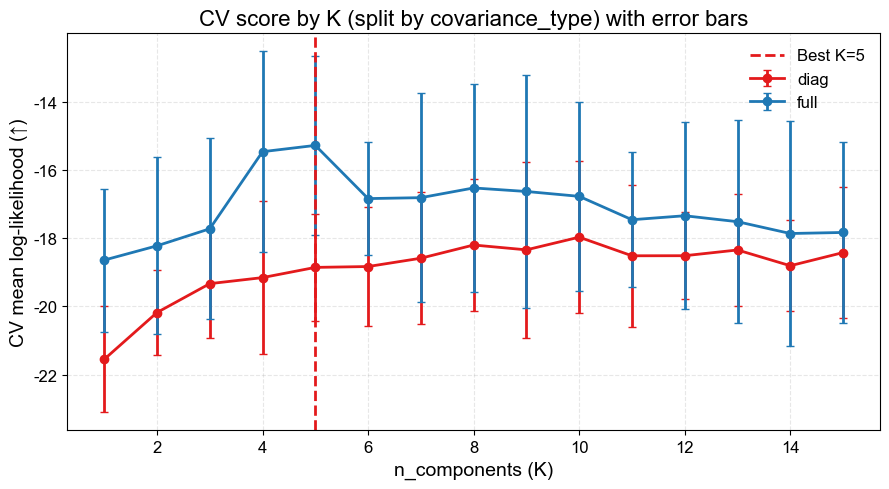

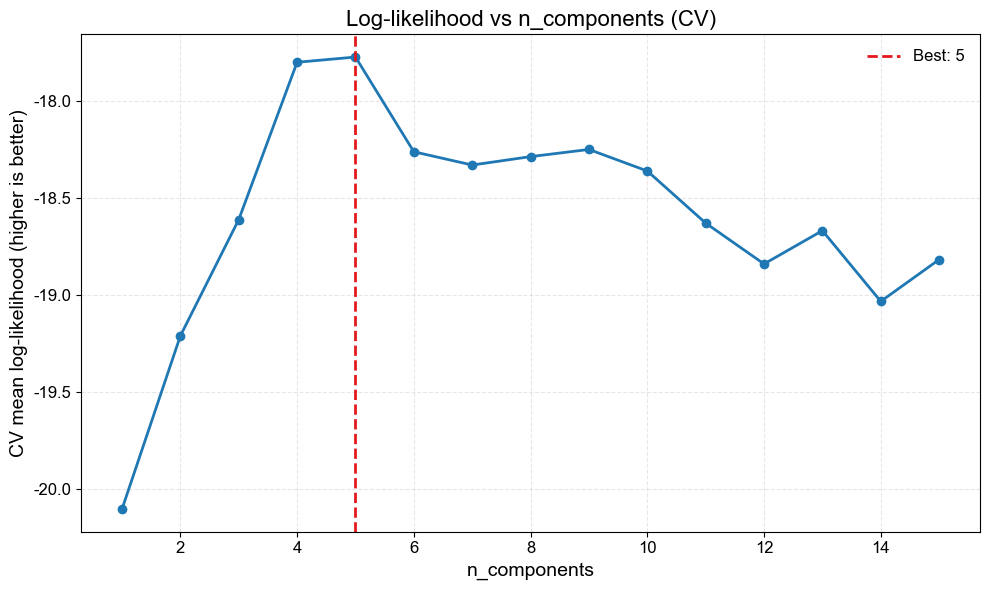


✅ 完整Pipeline已保存到: gmm_model_5c_fixed.pkl
✅ 修复版本GMM模型训练完成！

开始环境相似度评分...
✅ 环境相似度得分计算完成！
密度范围: [0.000000, 0.901831]
环境分数范围: [0.000000, 0.950331]
标定来源: 未知
使用的标定均值: -14.860516
✅ Results saved: data/US_data/abandon_filtered_with_gmm_scores.csv
(Use merge_id to join with original data by index, or spatial join with lat/lon)

Generating key performance plots...
✅ Plots saved: data/US_data\gmm_env_key_plots_fixed_20250811_162530.png


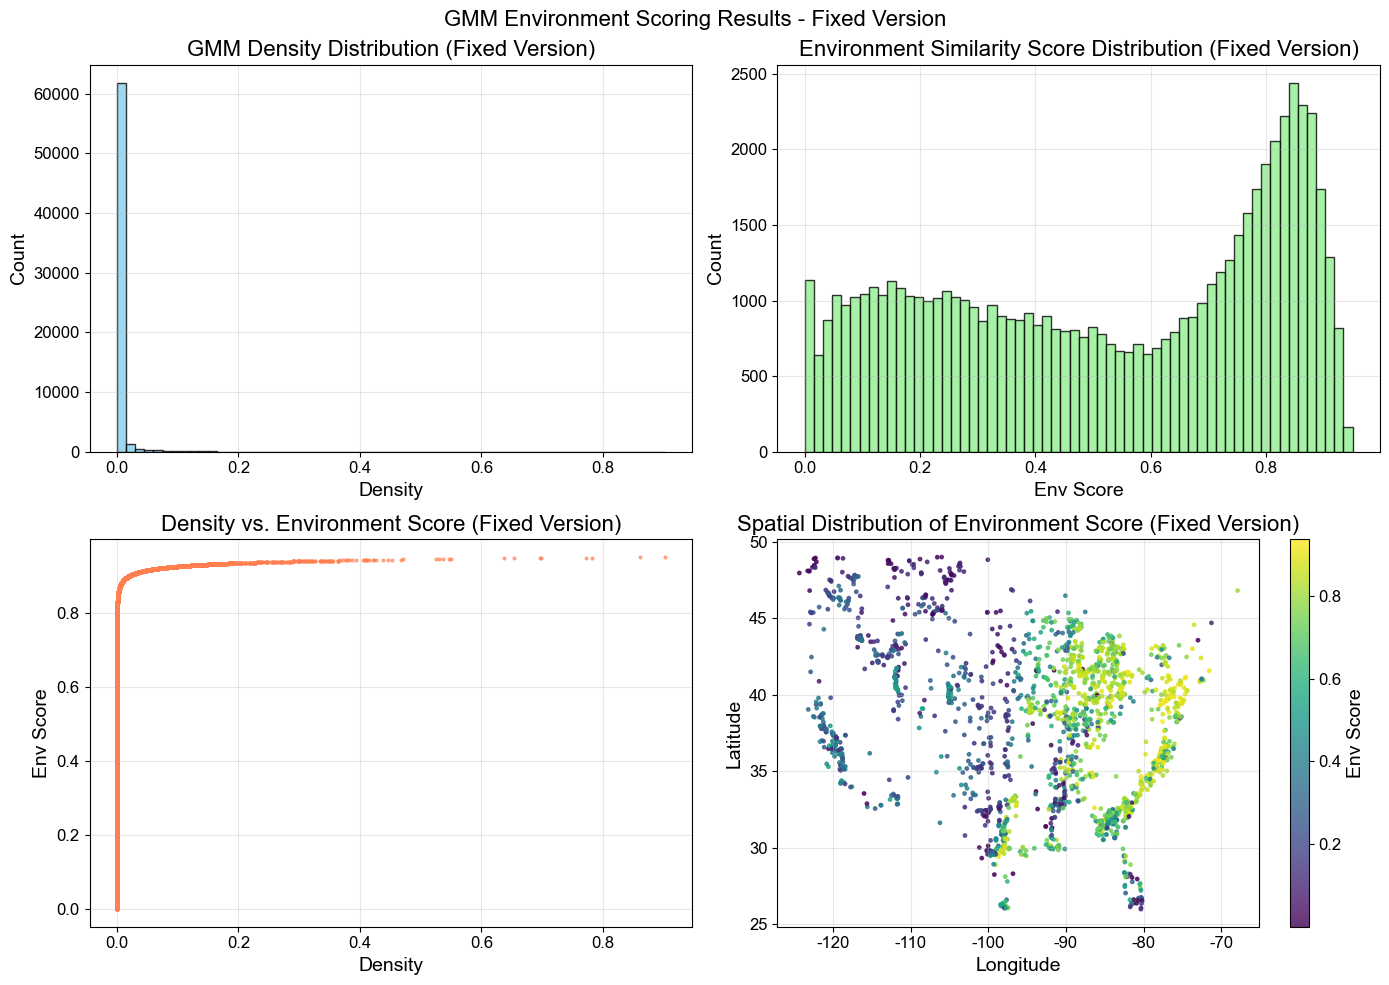

In [21]:
# -*- coding: utf-8 -*-
"""
Run GMM environment scoring on US mainland points.
- 使用第二次裁剪后的 df_embedding_fill[features_no_coords] 训练
- 对 df_abandon_filtered[features_no_coords] 打分
- 仅保存最终结果（含 merge_id 列，便于与原数据拼接）
- 输出关键性能图表（密度分布、得分分布、密度-得分散点）
"""

from function import *  # 需要包含: PATHS, load_abandon, load_embedding, fill_nonpositive_with_nearest,
                        # filter_duplicates, select_and_train_gmm, 
                        # NUMERIC_FEATURES, CAT_COLS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':
    np.random.seed(42)

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_states)
    df_embedding = clip_data_with_us_states(df_embedding, us_states)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

     # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]

    # 为稳妥，取交集（防止列名不在 DataFrame 中导致 KeyError）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]
    print(f"使用的特征数量: {len(features_no_coords)}")
    print(f"特征列表: {features_no_coords}")

    # ---------------------------
    # 4) 训练修复版本的GMM（解决数据泄露）
    # ---------------------------
    print("\n开始训练修复版本的GMM模型...")
    gmm_pipeline = select_and_train_gmm(df_embedding_fill[features_no_coords])

    print("✅ 修复版本GMM模型训练完成！")

    # # 训练完成后，计算并保存标定参数（测试一致性，慎用！！！）
    # print("\n计算并保存标定参数...")

    # X_train_processed = gmm_pipeline.named_steps['preprocessor'].transform(df_embedding_fill[features_no_coords])
    # gmm_trained = gmm_pipeline.named_steps['gmm']
    # logdens_train = gmm_trained.score_samples(X_train_processed)

    # # 保存标定参数到pipeline
    # calibration_stats = {
    #     'mu': float(logdens_train.mean()),
    #     'mean': float(logdens_train.mean()),
    #     'std': float(logdens_train.std()),
    #     'min': float(logdens_train.min()),
    #     'max': float(logdens_train.max()),
    #     'n_samples': len(logdens_train),
    #     'method': 'sigmoid',
    #     'sigmoid_alpha': 1.0
    # }

    # # 将标定参数附加到pipeline
    # gmm_pipeline.calibration_ = calibration_stats

    # print(f"✅ 标定参数已保存:")
    # print(f"   均值: {calibration_stats['mu']:.6f}")
    # print(f"   标准差: {calibration_stats['std']:.6f}")
    # print(f"   范围: [{calibration_stats['min']:.6f}, {calibration_stats['max']:.6f}]")

    # ---------------------------
    # 5) 使用修复版本进行环境评分
    # ---------------------------
    print("\n开始环境相似度评分...")

    # 使用你的 score_env函数
    dens, env_scores, stats = score_env(
        gmm_pipeline, 
        df_abandon_filtered[features_no_coords],
        method='sigmoid',
        sigmoid_alpha=0.2,
        reference_stats=None,  
        return_logdens=False
    )

    print("✅ 环境相似度得分计算完成！")
    print(f"密度范围: [{dens.min():.6f}, {dens.max():.6f}]")
    print(f"环境分数范围: [{env_scores.min():.6f}, {env_scores.max():.6f}]")
    print(f"标定来源: {stats.get('calibration_source', '未知')}")
    print(f"使用的标定均值: {stats['mu']:.6f}")

    # ---------------------------
    # 6) 一致性验证测试
    # ---------------------------
    # print("\n进行一致性验证测试...")

    # # 测试样本
    # test_sample = df_abandon_filtered[features_no_coords].head(1000)

    # # 第一次预测
    # dens1, scores1, stats1 = score_env(
    #     gmm_pipeline, 
    #     test_sample,
    #     method='sigmoid',
    #     sigmoid_alpha=1.0
    # )

    # # 第二次预测（应该完全一致）
    # dens2, scores2, stats2 = score_env(
    #     gmm_pipeline, 
    #     test_sample,
    #     method='sigmoid',
    #     sigmoid_alpha=1.0
    # )

    # # # 检查一致性
    # # dens_consistent = np.allclose(dens1, dens2, rtol=1e-10)
    # # scores_consistent = np.allclose(scores1, scores2, rtol=1e-10)

    # print(f"✅ 密度预测一致性: {dens_consistent}")
    # print(f"✅ 分数预测一致性: {scores_consistent}")

    # if dens_consistent and scores_consistent:
    #     print("🎉 完美！预测结果完全一致")
    # else:
    #     print("⚠️ 警告：预测结果不一致，请检查")

    # ---------------------------
    # 6) 保存最终结果（含 merge_id 便于回拼）
    # ---------------------------
    save_dir = "data/US_data"
    os.makedirs(save_dir, exist_ok=True)
    # 将环境分数和密度等结果与原始数据通过 'lat' 和 'lon' 两列组合 merge 合并输出
    # 构建结果DataFrame
    results = pd.DataFrame({
        'lon': df_abandon_filtered['lon'].values,
        'lat': df_abandon_filtered['lat'].values,
        'gmm_density': dens,
        'gmm_env_score': env_scores,
    })

    # 将results merge到df_abandon_filtered
    df_abandon_filtered = pd.merge(
        df_abandon_filtered,
        results[['lat', 'lon', 'gmm_density', 'gmm_env_score']],
        on=['lat', 'lon'],
        how='left'
    )

    # 输出合并后的结果
    df_abandon_filtered.to_csv('data/US_data/abandon_filtered_with_gmm_scores.csv', index=False)

    print(f"✅ Results saved: data/US_data/abandon_filtered_with_gmm_scores.csv")
    print("(Use merge_id to join with original data by index, or spatial join with lat/lon)")


    # ---------------------------
    # 7) 测试模型加载和预测
    # ---------------------------
    # print("\n测试模型加载和预测...")
    
    # # 假设模型文件名（根据实际训练结果调整）
    # model_files = [f for f in os.listdir('.') if f.startswith('gmm_model_') and f.endswith('_fixed.pkl')]
    
    # if model_files:
    #     model_filename = model_files[0]  # 选择第一个匹配的文件
    #     print(f"找到保存的模型: {model_filename}")
        
    #     # 测试样本
    #     test_sample = df_abandon_filtered[features_no_coords].head(1000)

    #     print("\n方法1：使用 predict_with_saved_pipeline_v2")
    #     dens_loaded, scores_loaded, stats_loaded = predict_with_saved_pipeline_v2(
    #         test_sample, 
    #         model_filename, 
    #         method='sigmoid',
    #         sigmoid_alpha=1.0,
    #         return_stats=True
    #     )
        
    #     if dens_loaded is not None:
    #         print(f"✅ 模型加载测试成功！")
    #         print(f"测试样本预测密度范围: [{dens_loaded.min():.6f}, {dens_loaded.max():.6f}]")
    #         print(f"测试样本预测分数范围: [{scores_loaded.min():.6f}, {scores_loaded.max():.6f}]")
    #         print(f"标定来源: {stats_loaded.get('calibration_source', '未知')}")
            
    #         # 验证一致性（前1000个样本）
    #         original_dens = dens[:1000]
    #         original_scores = env_scores[:1000]
    #         consistency_dens = np.allclose(original_dens, dens_loaded, rtol=1e-6)
    #         consistency_scores = np.allclose(original_scores, scores_loaded, rtol=1e-6)
            
    #         print(f"密度预测一致性: {consistency_dens}")
    #         print(f"分数预测一致性: {consistency_scores}")
            
    #         if consistency_dens and consistency_scores:
    #             print("🎉 完美！预测结果完全一致")
    #         else:
    #             print("ℹ️ 注意：可能由于不同的标定参数导致轻微差异")
    #     else:
    #         print("⚠️ 模型加载测试失败")
    

    # ---------------------------
    # 8) 关键性能图表
    # ---------------------------
    print("\nGenerating key performance plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Density distribution
    axes[0, 0].hist(dens, bins=60, alpha=0.8, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('GMM Density Distribution (Fixed Version)')
    axes[0, 0].set_xlabel('Density')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)

    # Environment score distribution
    axes[0, 1].hist(env_scores, bins=60, alpha=0.8, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Environment Similarity Score Distribution (Fixed Version)')
    axes[0, 1].set_xlabel('Env Score')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3)

    # Density vs. Score
    axes[1, 0].scatter(dens, env_scores, s=4, alpha=0.6, c='coral')
    axes[1, 0].set_title('Density vs. Environment Score (Fixed Version)')
    axes[1, 0].set_xlabel('Density')
    axes[1, 0].set_ylabel('Env Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Spatial sampling visualization
    sample_n = min(2000, len(results))
    idx = np.random.choice(len(results), sample_n, replace=False)
    sc = axes[1, 1].scatter(results.loc[idx, 'lon'], results.loc[idx, 'lat'],
                            c=results.loc[idx, 'gmm_env_score'].values, s=6, alpha=0.8, cmap='viridis')
    axes[1, 1].set_title('Spatial Distribution of Environment Score (Fixed Version)')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(sc, ax=axes[1, 1], label='Env Score')

    plt.suptitle('GMM Environment Scoring Results - Fixed Version', fontsize=16, y=0.98)
    plt.tight_layout()
    
    # 保存图表
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_path = os.path.join(save_dir, f"gmm_env_key_plots_fixed_{timestamp}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plots saved: {fig_path}")
    plt.show()

    # ---------------------------
    # 9) 模型信息总结
    # ---------------------------
    # print("\n" + "=" * 60)
    # print("模型信息总结:")
    # print("=" * 60)
    
    # if gmm_pipeline:
    #     # 获取预处理器信息
    #     preprocessor = gmm_pipeline.named_steps['preprocessor']
    #     feature_info = preprocessor.get_feature_info()
        
    #     # 获取GMM信息
    #     gmm = gmm_pipeline.named_steps['gmm']
        
    #     print(f"✅ 使用修复版本Pipeline，解决数据泄露问题")
    #     print(f"✅ GMM组件数: {gmm.n_components}")
    #     print(f"✅ 协方差类型: {gmm.covariance_type}")
    #     print(f"✅ 分类特征信息: {feature_info}")
    #     print(f"✅ 训练样本数: {len(df_embedding_fill)}")
    #     print(f"✅ 预测样本数: {len(df_abandon_filtered)}")
    #     print(f"✅ 特征数量: {len(features_no_coords)}")
        
        # if model_files:
        #     print(f"✅ 模型文件: {model_files[0]}")
        
    print("=" * 60)

In [ ]:
df_abandon_filtered.gmm_env_score.describe()

count    6.498200e+04
mean     5.321479e-01
std      3.533017e-01
min      6.780135e-18
25%      1.661549e-01
50%      5.817183e-01
75%      8.886647e-01
max      9.881927e-01
Name: gmm_env_score, dtype: float64

## GMM估计输出数据检查

In [ ]:
def analyze_low_density_distribution(df, density_col='gmm_density', env_score_col='gmm_env_score'):
    """
    重点分析0-0.2密度区间的数据分布，并自动检测列名是否存在，避免KeyError。
    
    Parameters:
    -----------
    df : DataFrame
        包含density和env_score列的数据框
    density_col : str
        密度列名
    env_score_col : str
        环境分数列名
    
    Returns:
    --------
    dict : 分析结果字典
    """
    import numpy as np
    import pandas as pd

    # 自动检测列名（忽略大小写和下划线差异）
    def find_col(df, target):
        target_norm = target.lower().replace("_", "")
        for col in df.columns:
            if col.lower().replace("_", "") == target_norm:
                return col
        raise KeyError(f"Column '{target}' not found in DataFrame. Available columns: {list(df.columns)}")

    density_col_real = find_col(df, density_col)
    env_score_col_real = find_col(df, env_score_col)

    # 筛选0-0.2密度区间的数据
    low_density_mask = (df[density_col_real] >= 0) & (df[density_col_real] <= 0.2)
    low_density_data = df[low_density_mask].copy()

    # 统计0值的数量
    zero_density_count = (df[density_col_real] == 0).sum()
    near_zero_count = (df[density_col_real] <= 1e-10).sum()  # 接近0的值

    # 环境分数在不同密度区间的分布（安全处理：如无数据则返回空Series的describe）
    def safe_describe(sub_df):
        if len(sub_df) == 0:
            return pd.Series(dtype=float).describe()
        return sub_df[env_score_col_real].describe()

    env_score_by_density_ranges = {
        '0.0': safe_describe(df[df[density_col_real] == 0]),
        '0.0-0.01': safe_describe(df[(df[density_col_real] > 0) & (df[density_col_real] <= 0.01)]),
        '0.01-0.05': safe_describe(df[(df[density_col_real] > 0.01) & (df[density_col_real] <= 0.05)]),
        '0.05-0.1': safe_describe(df[(df[density_col_real] > 0.05) & (df[density_col_real] <= 0.1)]),
        '0.1-0.2': safe_describe(df[(df[density_col_real] > 0.1) & (df[density_col_real] <= 0.2)]),
    }

    # 0-0.2区间的详细统计
    analysis_results = {
        'total_records': len(df),
        'zero_density_count': zero_density_count,
        'near_zero_count': near_zero_count,
        'low_density_0_02_count': len(low_density_data),
        'low_density_percentage': len(low_density_data) / len(df) * 100 if len(df) > 0 else 0.0,
        # 0-0.2区间的环境分数分布
        'env_score_stats_0_02': low_density_data[env_score_col_real].describe() if len(low_density_data) > 0 else pd.Series(dtype=float).describe(),
        # 密度分布统计
        'density_stats_0_02': low_density_data[density_col_real].describe() if len(low_density_data) > 0 else pd.Series(dtype=float).describe(),
        # 环境分数在不同密度区间的分布
        'env_score_by_density_ranges': env_score_by_density_ranges
    }

    return analysis_results

def plot_low_density_analysis(df, density_col='gmm_density', env_score_col='gmm_env_score'):
    """
    可视化0-0.2密度区间的分布，自动检测列名。
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # 自动检测列名
    def find_col(df, target):
        target_norm = target.lower().replace("_", "")
        for col in df.columns:
            if col.lower().replace("_", "") == target_norm:
                return col
        raise KeyError(f"Column '{target}' not found in DataFrame. Available columns: {list(df.columns)}")

    density_col_real = find_col(df, density_col)
    env_score_col_real = find_col(df, env_score_col)

    # 筛选数据
    low_density_mask = (df[density_col_real] >= 0) & (df[density_col_real] <= 0.2)
    low_density_data = df[low_density_mask]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. 0-0.2密度区间的直方图
    axes[0,0].hist(low_density_data[density_col_real], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Density Distribution (0-0.2)')
    axes[0,0].set_xlabel('Density')
    axes[0,0].set_ylabel('Count')
    axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Density = 0')
    axes[0,0].legend()

    # 2. 0-0.2区间的环境分数分布
    axes[0,1].hist(low_density_data[env_score_col_real], bins=30, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Environment Score Distribution (Density 0-0.2)')
    axes[0,1].set_xlabel('Environment Score')
    axes[0,1].set_ylabel('Count')

    # 3. 密度vs环境分数的散点图（0-0.2区间）
    axes[1,0].scatter(low_density_data[density_col_real], low_density_data[env_score_col_real], 
                      alpha=0.5, s=1, color='purple')
    axes[1,0].set_title('Density vs Environment Score (0-0.2)')
    axes[1,0].set_xlabel('Density')
    axes[1,0].set_ylabel('Environment Score')

    # 4. 不同密度区间的环境分数箱线图
    density_ranges = [
        (0, 0, '0.0'),
        (0, 0.01, '0.0-0.01'),
        (0.01, 0.05, '0.01-0.05'),
        (0.05, 0.1, '0.05-0.1'),
        (0.1, 0.2, '0.1-0.2')
    ]

    box_data = []
    labels = []

    for start, end, label in density_ranges:
        if start == end:
            mask = (df[density_col_real] == start)
        else:
            mask = (df[density_col_real] > start) & (df[density_col_real] <= end)

        if mask.sum() > 0:
            box_data.append(df.loc[mask, env_score_col_real].values)
            labels.append(f'{label}\n(n={mask.sum()})')

    if box_data:
        axes[1,1].boxplot(box_data, labels=labels)
    axes[1,1].set_title('Environment Score by Density Ranges')
    axes[1,1].set_ylabel('Environment Score')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return fig

# 使用示例：
# 假设你的数据框名为 df_result
# results = analyze_low_density_distribution(df_result)
# plot_low_density_analysis(df_result)

# 打印关键统计信息
def print_key_statistics(results):
    """打印关键统计信息"""
    print("=== 低密度区间(0-0.2)分析结果 ===")
    print(f"总记录数: {results['total_records']:,}")
    print(f"密度为0的记录数: {results['zero_density_count']:,}")
    print(f"接近0的记录数(≤1e-10): {results['near_zero_count']:,}")
    print(f"0-0.2密度区间记录数: {results['low_density_0_02_count']:,}")
    print(f"0-0.2区间占比: {results['low_density_percentage']:.2f}%")

    print("\n=== 密度为0的环境分数分布 ===")
    print(results['env_score_by_density_ranges']['0.0'])

    print("\n=== 0-0.01密度区间的环境分数分布 ===")
    print(results['env_score_by_density_ranges']['0.0-0.01'])

=== 低密度区间(0-0.2)分析结果 ===
总记录数: 64,982
密度为0的记录数: 0
接近0的记录数(≤1e-10): 10,067
0-0.2密度区间记录数: 64,845
0-0.2区间占比: 99.79%

=== 密度为0的环境分数分布 ===
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

=== 0-0.01密度区间的环境分数分布 ===
count    6.109500e+04
mean     5.167794e-01
std      4.581387e-01
min      9.139429e-58
25%      3.224124e-03
50%      5.849656e-01
75%      9.976517e-01
max      9.999618e-01
Name: gmm_env_score, dtype: float64


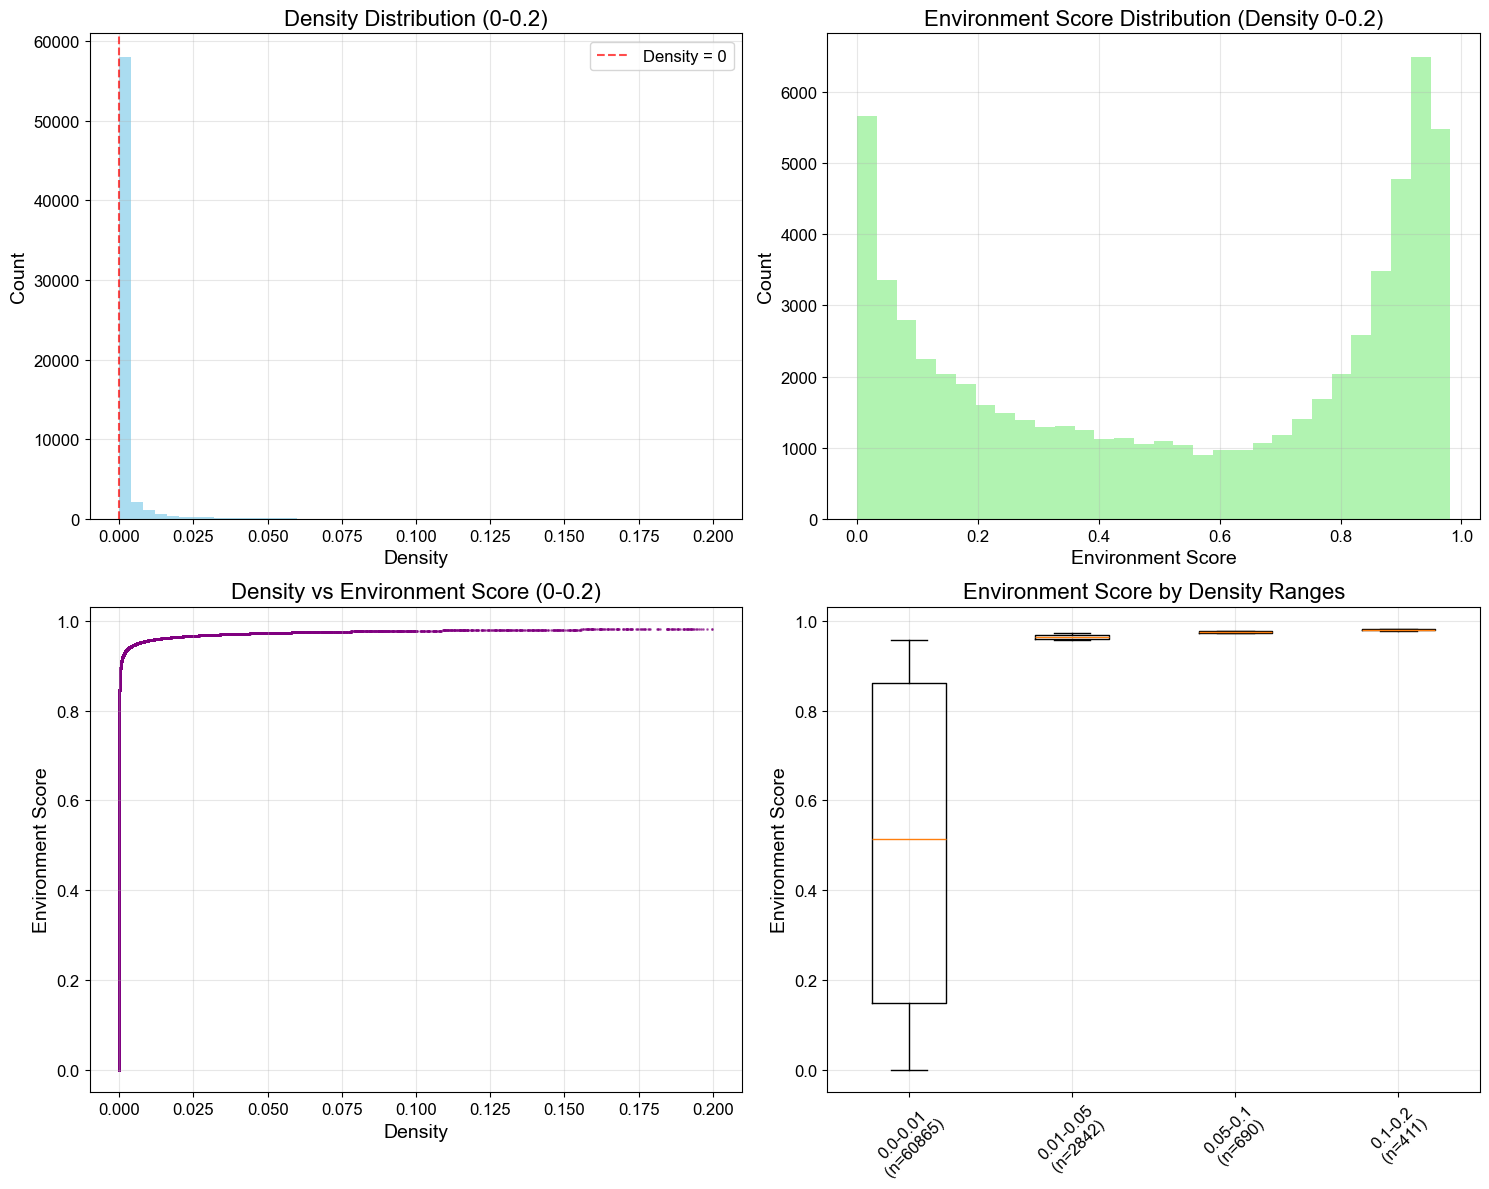

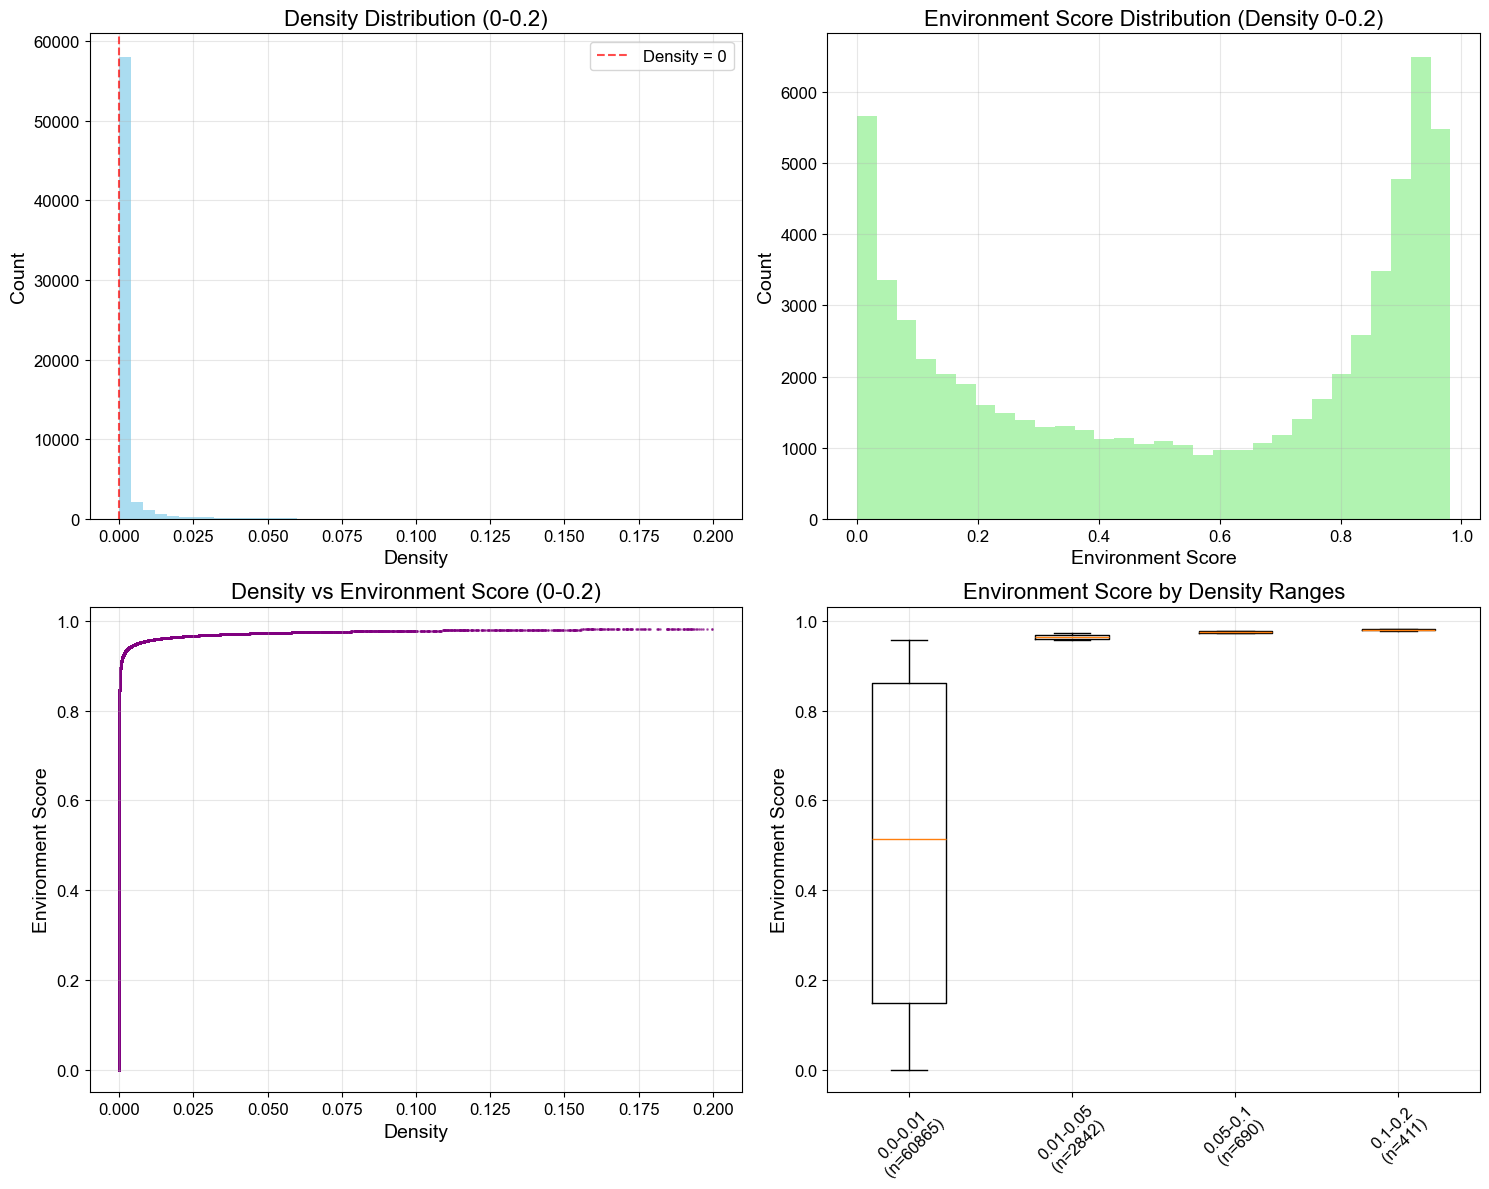

In [20]:
# 1. 运行分析

result = pd.read_csv(r"data\US_data\gmm_env_scores_US.csv")
results_2 = analyze_low_density_distribution(result)

# 2. 打印关键统计
print_key_statistics(results_2)

# 3. 可视化分析
plot_low_density_analysis(results)

In [ ]:
result

,merge_id,lon,lat,gmm_density,gmm_env_score,landcover
0,0,-105.929170,31.320833,1.386177e-10,0.000363,2.0
1,1,-105.929170,31.329166,1.187769e-09,0.003099,3.0
2,2,-105.937500,31.337500,1.624183e-09,0.004233,3.0
3,3,-105.929170,31.337500,4.831509e-10,0.001263,2.0
4,4,-105.937500,31.345833,3.560344e-08,0.085239,2.0
...,...,...,...,...,...,...
64977,64977,-67.920830,46.937500,6.482269e-06,0.944337,2.0
64978,64978,-67.962500,47.145832,1.670450e-07,0.304198,2.0
64979,64979,-68.620834,47.237500,2.171639e-08,0.053780,2.0
64980,64980,-68.354164,47.254166,6.151872e-08,0.138679,2.0


# Version 2（深度学习版本）

In [ ]:
from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_states)
    df_embedding = clip_data_with_us_states(df_embedding, us_states)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

    # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
    # 只保留在 df_embedding_fill 列中实际存在的特征（防止有些特征名在数据中不存在）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

    
    complete_results = run_correct_training_pipeline(
            df_positive=df_embedding_fill,          # 正样本
            df_prediction_pool=df_abandon_filtered,  # 预测样本池
            features_no_coords=features_no_coords,
            negative_ratio=0.3,
            sampling_strategy="simple",
            difficulty_levels=3,
            test_size=0.2,
            val_size=0.2,
            epochs=50,
            batch_size=32,
            random_state=42,
            hidden_layers=[128, 64, 32],
            dropout_rate=0.3,
            learning_rate=0.001,
            run_shap=True
    )
    
    if complete_results is not None:

        evaluation_results = enhanced_model_evaluation_with_pu(
            complete_results, 
            pi_estimate=0.2,              
            traditional_metrics=True,       
            pu_metrics=True,              
            cost_fp=2.0,                   
            cost_fn=1.0                    
        )

        # 输出关键信息
        pu_summary = evaluation_results["pu_learning"]["summary"]
        print(f"\n🎯 最终推荐:")
        print(f"   最佳阈值: {pu_summary['best_threshold']:.3f}")
        print(f"   预期覆盖率: {pu_summary['best_detection_rate']:.1%}")
        print(f"   预期误报率: {pu_summary['best_fpr']:.1%}")
        print(f"   采样偏差程度: {pu_summary.get('sampling_bias_factor', 0):.3f}")

        # 保存结果
        save_dir = "data/US_data"
        os.makedirs(save_dir, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # 保存最终预测结果

        saved_model_path = save_complete_model_pipeline(
        gmm_pipeline=complete_results['gmm_pipeline'],
        dl_model=complete_results['training_results']['model'],
        features=features_no_coords,
        config=complete_results['config'],
        retrained_preprocessor=complete_results['training_results']['preprocessor'],  
        save_dir="data/US_data",
        model_name=f"landuse_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        )

        final_results = complete_results['final_results']
        output_file = os.path.join(save_dir, f"correct_pipeline_results_{timestamp}.csv")
        final_results.to_csv(output_file, index=False)
        

        
        print(f"\n✅ 结果已保存:")
        print(f"\n最终统计:")
        print(f"  - 总样本数: {len(final_results):,}")
        print(f"  - 负样本数: {len(complete_results['negative_samples']):,}")
        print(f"  - 预测样本数: {len(complete_results['prediction_results']):,}")
        print(f"  - 预测为正类: {final_results['predicted_label'].sum():,}")
        print(f"  - 正类比例: {final_results['predicted_label'].mean():.3%}")
    
    else:
        print("❌ 训练管道执行失败")

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


In [ ]:
# # 将env_scores匹配到原始样本的经纬度上并保存
# df_abandon_filtered['env_scores'] = env_scores
# # Try saving with different encoding
# df_abandon_filtered.to_csv('./data/abandon_filtered_with_scores.csv', index=False)# 绘制地图
# plt.figure(figsize=(10,6))

# # 绘制待预测点
# plt.scatter(df_abandon_filtered['lon'], df_abandon_filtered['lat'], 
#            c=df_abandon_filtered['env_scores'], cmap='viridis',
#            alpha=0.5, label='Prediction Points')

# # 叠加训练样本点
# plt.scatter(df_embedding_fill['lon'], df_embedding_fill['lat'],
#            color='red', alpha=0.5, s=20, label='Training Points')

# plt.colorbar(label='Environmental Scores')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Spatial Distribution of Environmental Scores')
# plt.legend()
# plt.show()

In [ ]:
df_abandon

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
805,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,1.104119,622567.20,22.570979,0.000000,0.161280,109.755022,60.677334,21.335989,2934.915273,2.750262
807,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,1.104119,622567.20,22.570979,0.000000,0.142680,109.755022,45.031578,21.334290,2934.829175,2.751782
808,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,0.399327,622567.20,22.570979,0.000000,0.151240,109.755022,38.084999,21.337654,2934.583333,2.752204
809,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,3.593287,622567.20,22.570979,0.000000,0.134330,109.755022,26.303532,21.336290,2934.584702,2.758872
810,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,5.603361,622567.20,22.570979,0.000000,0.182301,109.755022,39.406666,21.343910,2934.581940,2.771071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70592,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,218.050890,622564.50,4.273278,14.490743,1.000655,129.836817,74.197998,12.735363,2768.901404,3.429452
70601,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,9.665760,622564.30,32.119901,0.000000,3.852393,92.798418,73.082001,12.262959,2766.375025,3.813229
70607,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,141.555110,622564.00,3.471587,33.915221,1.910013,80.651057,54.858932,12.550031,2768.493367,3.047965
70608,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,17.156588,622564.06,8.030265,0.061349,1.939035,91.262543,74.170227,12.486876,2765.084545,4.128394
